# Imports

In [83]:
import matplotlib.pyplot as plt
import random as rd
from time import time
import seaborn as sns
import numpy as np
import pandas as pd
import os
import numba as nb
import math

sns.set(style="ticks", context="talk", rc={'figure.figsize':(20,10), 'figure.dpi':300})
plt.style.use("dark_background")

# Functions

In [74]:
def read_problem_file(file):
    flag = False
    file = open(file)
    l = 0
    temp = []
    for line in file.readlines():
        arr = line.split('\t')
        arr[-1] = arr[-1][:-1]
        if l != 0:
            arr = [int(numeric_string) for numeric_string in arr]
            if (l+1) % (jobs+2) == 0:
                if not flag:
                    pt = temp
                flag = True
                temp = []
            temp.append(arr)
        else:
            jobs = int(arr[0])
            machines = int(arr[1])
            pt = []
            ms = []
        l += 1
    file.close()

    return jobs, machines, np.matrix(pt), np.matrix(temp)

In [75]:
def make_schedule(processing_times, machine_sequence, genome, jobs, machines):
    schedule = [[] for i in range(machines)]
    schedule_temp = [row[:] for row in schedule]
    new_genome = genome[:]
    cost = 0
    
    job = 0
    for start in genome:
        start_t = start
        delay = 0
        increment = False
        op = 0
        
        is_job_scheduled = False
        while not is_job_scheduled:
            p_time = processing_times[job, op]
            machine = machine_sequence[job, op]
            
            is_op_scheduled = False
            invalid = False
            while not is_op_scheduled:
                start_op = start_t + delay
                end_op = start_t + p_time + delay

                schedule_temp[machine].sort()
                for task in schedule_temp[machine]:
                    # can the operation be scheduled?
                    if start_op >= task[0] and end_op <= task[1]:
                        invalid = True
                    elif start_op < task[0] and end_op > task[0]:
                        invalid = True
                    elif start_op < task[1] and end_op > task[1]:
                        invalid = True

                if invalid:
                    # step back beacause an operation schedule is invalid
                    is_op_scheduled = True
                    op = 0
                    start_t = start
                    schedule_temp = [row[:] for row in schedule]
                    if delay == -start:
                        increment = True
                        delay = 0
                        
                    if increment:
                        delay += 1
                    else:
                        delay -= 1
                else:
                    # operation scheduled
                    is_op_scheduled = True
                    schedule_temp[machine].append((start_op, end_op))
                    start_t = end_op - delay
                    op += 1
                    
            if op == machines:
                # all operations of a job is scheduled
                is_job_scheduled = True
                schedule = [row[:] for row in schedule_temp]
                new_genome[job] = start + delay
                if end_op > cost:
                    cost = end_op
                
                job += 1
                
    return schedule, new_genome, cost

# PSO

## Particle class

In [95]:
class Particle:
    def __init__(self, pos):
        self.pbest_fit = float('inf')
        self.position = np.array(pos)
        self.velocity = np.array([0]*len(pos))
        self.pbest_pos = np.copy(self.position)
                
    def fly(self):
        for i in range(len(self.position)):
            new_pos = np.copy(self.position[i] + self.velocity[i])
            if new_pos < 0:
                new_pos = 0
            self.position[i] = np.round(new_pos)

## PSO Algorithm

In [96]:
class PSO:
    def __init__(self, n_particles, iters, problem, file_path='', W=0.7, C1=1, C2=1):
        self.W, self.C1, self.C2 = W, C1, C2
        self.iters = iters
        self.n_particles = n_particles
        self.particles = []
        
        self.jobs, self.machines, self.processing_times, self.machine_sequence = read_problem_file(
            file_path+problem+'.txt')
        self.machine_sequence -= 1
        self.min_value = 0
        self.min_job_cost = min([sum(self.processing_times[i].flat) for i in range(self.processing_times.shape[0])])
        self.max_value = sum(self.processing_times.flat) - self.min_job_cost
        
        self.gbest_fit = float('inf')
        self.gbest_pos = np.array(self.init())
        for _ in range(n_particles):
            self.particles.append(Particle(self.init()))

    def init(self):
        return rd.choices(list(range(0, self.max_value)), k=self.jobs)
                      
    def calculate_fitness(self, solution):
        self.schedule, solution, fit = make_schedule(self.processing_times, 
                                                     self.machine_sequence, 
                                                     solution, self.jobs, self.machines)
        return solution, fit
        
    def set_pbest_gbest(self):
        for p in self.particles:
            sol, fit = self.calculate_fitness(p.position)
            p.position = np.copy(sol)
            if fit < p.pbest_fit:
                p.pbest_fit = fit
                p.pbest_pos = np.copy(sol)
            if fit < self.gbest_fit:
                self.gbest_fit = fit
                self.gbest_pos = np.copy(sol)
                     
    def fly(self, W ,C1, C2):
        for p in self.particles:
            velocity = np.round((W*p.velocity) + (C1*rd.random()) * (p.pbest_pos - p.position) + (C2*rd.random()) * (self.gbest_pos - p.position))
            p.velocity = np.copy(velocity)
            p.fly()       
        
    def fit(self, stop=10, verbose=-1):
        stuck = 0
        i = 0
        while i < self.iters and stuck < stop:
            self.fly(W=self.W, C1=self.C1, C2=self.C2)
            gbest_prev = self.gbest_fit
            self.set_pbest_gbest()

            if self.gbest_fit == gbest_prev:
                stuck += 1
            else:
                stuck = 0

            if verbose >= 1:
                if (i+1) % verbose == 0 or i == 0:
                    print('Iteration:', i+1,'Best cost is', self.gbest_fit)

            i += 1
            
    def get_best(self):
        return self.gbest_fit, self.gbest_pos

# Run model

In [ ]:
n_runs = 30
best_solutions = []
execution_times = []
for i in range(n_runs):
    pso = PSO(n_particles=100, iters=100, problem='ft06', file_path='problems/')
    start_time = time()
    pso.fit(stop=100)
    elapsed_time = time() - start_time
    execution_times.append(elapsed_time)
    best_solutions.append(pso.gbest_fit)
f = open('solutions/ft06_PSO.txt', 'a+')
f.write(str(best_solutions) + '\n')
f.write(str(execution_times) + '\n\n')
f.close()

# Simulated Annealing

## Agent Class

In [97]:
class Agent:
    def __init__(self, size=0, min_value=-5, max_value=5, random=False):
        if random:
            self.vector = [round(rd.uniform(min_value, max_value)) for i in range(size)]

## SA Algorithm

In [98]:
class Simulated_Annealing_Algorithm:
    def __init__(self, init_temp, T_factor, k, problem, file_path=''):
        self.init_temp = init_temp
        self.T_factor = T_factor
        self.data = []
        self.k = k
        self.jobs, self.machines, self.processing_times, self.machine_sequence = read_problem_file(
            file_path+problem+'.txt')
        self.machine_sequence -= 1
        self.min_value = 0
        self.min_job_cost = min([sum(self.processing_times[i].flat) for i in range(self.processing_times.shape[0])])
        self.max_value = sum(self.processing_times.flat) - self.min_job_cost
        self.perturb_value = self.max_value * 0.2
        
    def perturb(self, vector):
        perturb_value = round(rd.uniform(-self.perturb_value, self.perturb_value))
        k = rd.randint(0, self.jobs - 1)
        if vector[k] + perturb_value < 0:
            perturb_value = -vector[k]
        vector[k] += perturb_value 
        return vector

    def calculate_fitness(self, vector):
        self.schedule, vector, fitness = make_schedule(self.processing_times, 
                                                  self.machine_sequence, 
                                                  vector, self.jobs, self.machines)
        return fitness
    
    def fit(self, stop=10, verbose=-1):
        i = 0
        bc = float('inf')
        s = Agent(size=self.jobs, min_value=self.min_value, max_value=self.max_value, random=True)
        sp = Agent()
        T = self.init_temp
        stuck = 0
        while T > 1e-8 and stuck < stop:
            if verbose >= 1:
                if len(self.data) % verbose == 0:
                    print('Temperature:', T, 'best cost is', bc)
            for i in range(self.k):
                sp.vector = self.perturb(s.vector[:])
                bc = self.calculate_fitness(s.vector)
                ce = self.calculate_fitness(sp.vector) - bc
                if ce <= 0 or rd.random() < math.exp(-ce/T):
                    s.vector = sp.vector[:]


            self.data.append(self.calculate_fitness(s.vector))
            T -= self.T_factor*T
            if len(self.data) > 1:
                if self.data[-1] == self.data[-2]:
                    stuck += 1
                else:
                    stuck = 0
        self.sbest = s.vector
        self.fbest = self.data[-1]
        
    def iters_plot(self):
        plt.ylabel('Fitness')
        plt.xlabel('Iterations')
        plt.plot(range(1, len(self.data)+1), self.data, c='cyan')
        plt.show()
        
    def get_best(self):
        return self.fbest, self.sbest

# Run model

In [ ]:
n_runs = 30
best_solutions = []
execution_times = []
for i in range(n_runs):
    model = Simulated_Annealing_Algorithm(init_temp=40, T_factor=0.2, k=50, problem='ft06', 
                                          file_path='problems/')

    start_time = time()
    model.fit(stop=100)
    elapsed_time = time() - start_time

    execution_times.append(elapsed_time)
    best_solutions.append(model.fbest)

f = open('solutions/ft06_SA.txt', 'a+')
f.write(str(best_solutions) + '\n')
f.write(str(execution_times) + '\n\n')
f.close()

# Genetic Algorithm

## Individual Class

In [99]:
class Individual:
    def __init__(self, jobs, machines, processing_times, machine_sequence, prob_mutation, 
                 mutation='swap', genome=[], random_genome=False, k=1, max_factor_scramble=0.5, 
                 problem='ft06', max_gen=100):
        self.jobs = jobs
        self.machines = machines
        self.processing_times = processing_times
        self.machine_sequence = machine_sequence
        self.prob_mutation = prob_mutation
        self.mutation = mutation
        self.k = k
        self.current_gen = 1
        self.max_gen = max_gen
        self.problem = problem
        self.max_factor_scramble = max_factor_scramble
        self.size = self.jobs
        self.min_job_cost = min([sum(self.processing_times[i].flat) for i in range(self.processing_times.shape[0])])
        self.max_cost = sum(self.processing_times.flat) - self.min_job_cost
        if random_genome:
            self.genome = rd.choices(range(self.max_cost), k=self.jobs)
        else:
            self.genome = genome
        
    def calculate_fitness(self, current_gen=0):
        self.current_gen = current_gen
        self.schedule, self.genome, self.fitness = make_schedule(self.processing_times, 
                                                                 self.machine_sequence, 
                                                                 self.genome, self.jobs, self.machines)
        
    def mutate(self):
        if rd.random() < self.prob_mutation:
            if self.mutation == 'swap':
                self.swap_mutation()
            elif self.mutation == 'kswap':
                self.kswap()
            elif self.mutation == 'scramble':
                self.scramble_mutation()
            elif self.mutation == 'inversion':
                self.inversion_mutation()
            elif self.mutation == 'uniform':
                self.uniform_mutation()
            elif self.mutation == 'non_uniform':
                self.non_uniform_mutation()
     
    def f_num(self):
        r2 = rd.random()
        return r2 * (1 - self.current_gen/self.max_gen)
    
    def non_uniform_mutation(self):
        k = rd.choice(list(range(0, self.size)))
        r = rd.random()
        min_value = 0
        max_value = self.max_cost
        if r >= 0.5:
            self.genome[k] = round((max_value - self.genome[k]) * self.f_num())
        else:
            self.genome[k] = round((min_value + self.genome[k]) * self.f_num())
    
    def uniform_mutation(self):
        k = rd.choice(list(range(0, self.size)))
        new_gen = rd.choice(list(range(0, self.max_cost+1)))
        self.genome[k] = new_gen
    
    def inversion_mutation(self):
        numbers = list(range(0, self.size))
        gens = rd.sample(numbers, k=2)
        gens.sort()
        selected_gens = self.genome[gens[0]:gens[1]]
        self.genome[gens[0]:gens[1]] = selected_gens[::-1]
            
    def scramble_mutation(self):
        factor = int(self.size*self.max_factor_scramble/2)
        numbers = list(range(factor-1, self.size-factor))
        gens = rd.sample(numbers, k=2)
        gens.sort()
        selected_gens = self.genome[gens[0]:gens[1]+1]
        rd.shuffle(selected_gens)
        self.genome[gens[0]:gens[1]+1] = selected_gens        
    
    def swap_mutation(self):
        numbers = list(range(0, self.size))
        gens = rd.sample(numbers, k=2)
        aux = self.genome[gens[0]]
        self.genome[gens[0]] = self.genome[gens[1]]
        self.genome[gens[1]] = aux
            
    def kswap(self):
        k = self.k
        for i in range(k):
            self.swap_mutation()
            
    def __lt__(self, other):
        if self.fitness < other.fitness:
            return -1
        else:
            return 0
        
    def __radd__(self, other):
        return self.fitness + other

## Population Class

In [100]:
class Population:
    def __init__(self, size, amount_parents_selection, prob_mutation, mutation='swap', 
                 crossover='cut_crossfill', k_crossover=1, k_mutation=1, max_factor_scramble=0.5, 
                 problem='ft06', max_gen=100, file_path=''):
        self.size = size
        self.prob_mutation = prob_mutation
        self.amount_parents_selection = amount_parents_selection
        self.mutation = mutation
        self.type_crossover = crossover
        self.max_gen = max_gen
        self.problem = problem
        self.max_factor_scramble = max_factor_scramble
        self.population = []
        self.jobs, self.machines, self.processing_times, self.machine_sequence = read_problem_file(
            file_path+problem+'.txt')
        self.machine_sequence -= 1
        self.k_crossover = round(k_crossover*self.jobs)
        self.k_mutation = round(k_mutation*self.jobs)
        for i in range(size):
            individual = Individual(self.jobs, self.machines, self.processing_times, 
                                    self.machine_sequence, prob_mutation=prob_mutation, 
                                    random_genome=True, mutation=mutation, k=k_mutation, 
                                    max_factor_scramble=max_factor_scramble, problem=problem, 
                                    max_gen=max_gen)
            individual.calculate_fitness()
            self.population.append(individual)
        self.population.sort()
        self.size_genome = self.population[0].jobs
        
    def statistics(self):        
        return self.population[0].fitness, sum(self.population)/self.size, self.population[-1].fitness
    
    def crossover(self, parent1, parent2):
        if self.type_crossover == 'cut_crossfill':
            return self.cut_crossfill(parent1, parent2)
        elif self.type_crossover == 'uniform':
            return self.uniform_crossover(parent1, parent2)
        elif self.type_crossover == 'ox1':
            return self.order_crossover_operator(parent1, parent2)
        elif self.type_crossover == 'average':
            return self.average_crossover(parent1, parent2)
    
    def make_child(self, ch_genome):
        child = Individual(self.jobs, self.machines, self.processing_times, self.machine_sequence, 
                         prob_mutation=self.prob_mutation, 
                         genome=ch_genome, mutation=self.mutation, k=self.k_mutation, 
                         max_factor_scramble=self.max_factor_scramble, problem=self.problem, 
                         max_gen=self.max_gen)
        
        return child
    
    def cut_crossfill(self, parent1, parent2):
        point = rd.randint(1, len(parent1) - 2)
        ch1_genome = self.do_cut_crossfill(parent1, parent2, point)
        ch2_genome = self.do_cut_crossfill(parent2, parent1, point)
        ch1 = self.make_child(ch1_genome)
        ch2 = self.make_child(ch2_genome)
        return [ch1, ch2]
    
    def do_cut_crossfill(self, parent1, parent2, point):
        k = point
        ch_genome = parent1[:point]
        while len(ch_genome) < len(parent1):
            k = k % len(parent1)
            ch_genome.append(parent2[k])
            k += 1
        return ch_genome

    def order_crossover_operator(self, parent1, parent2):
        point = rd.randint(1, self.size_genome - 2)
        ch1_genome = [-1] * self.size_genome
        ch2_genome = [-1] * self.size_genome

        for i in range(self.k_crossover):
            k = (point + i) % self.size_genome
            ch1_genome[k] = parent1[k]
            ch2_genome[k] = parent2[k]

        k = point + self.k_crossover
        j = k % self.size_genome
        l = self.k_crossover
        while l < self.size_genome:
            k = k % self.size_genome
            ch1_genome[j] = parent2[k]
            j = (j + 1) % self.size_genome
            l += 1
            k += 1

        k = point + self.k_crossover
        j = k % self.size_genome
        l = self.k_crossover
        while l < self.size_genome:
            k = k % self.size_genome
            ch2_genome[j] = parent1[k]
            j = (j + 1) % self.size_genome
            l += 1
            k += 1

        ch1 = self.make_child(ch1_genome)
        ch2 = self.make_child(ch2_genome)
        return [ch1, ch2]

    def uniform_crossover(self, parent1, parent2):
        ch1_genome = []
        ch2_genome = []
        
        i = 0
        while len(ch1_genome) < self.size_genome:
            if rd.random() <= 0.5:
                ch1_genome.append(parent1[i])
                ch2_genome.append(parent2[i])
            else:
                ch1_genome.append(parent2[i])
                ch2_genome.append(parent1[i])
                    
            i = (i + 1) % self.size_genome

        ch1 = self.make_child(ch1_genome)
        ch2 = self.make_child(ch2_genome)
        return [ch1, ch2]
    
    def average_crossover(self, parent1, parent2):
        ch_genome = [round((parent1[i] + parent2[i]) / 2) for i in range(len(parent1))]
        ch = self.make_child(ch_genome)
        return [ch]
                        
    def parents_selection(self, amount_random_selection):
        selected = rd.sample(self.population, k=amount_random_selection)
        selected.sort()
        children = self.crossover(selected[0].genome, selected[1].genome)
        for ch in children:
            ch.mutate()
        return children
    
    def survivors_selection(self, current_gen):
        children = self.parents_selection(self.amount_parents_selection)
        i = 0
        pop = self.population[::-1]
        j = 1
        for child in children:
            child.calculate_fitness(current_gen)
            j += 1
            if child.fitness < pop[i].fitness:
                self.replacement_poblation(child, i)
            i += 1
        self.population.sort()
        
    def replacement_poblation(self, new_child, pos):
        self.population[self.size-1-pos] = new_child
    
    def get_best_individual(self):
        return self.population[0]
            

## Evolutionary Algorithm Class

In [101]:
class Evolutionary_Algorithm:
    def __init__(self, size_population, prob_mutation, amount_parents_selection, 
                 generations, target_fitness, prob_recombination, mutation='swap', 
                 crossover='cut_crossfill', k_crossover=1, k_mutation=1, max_factor_scramble=0.25, 
                 problem='ft06', file_path=''):
        self.size_population = size_population
        self.prob_mutation = prob_mutation
        self.amount_parents_selection = amount_parents_selection
        self.generations = generations
        self.target_fitness = target_fitness
        self.prob_recombination = prob_recombination
        self.current_generation = 1
        self.mutation = mutation
        self.crossover = crossover
        self.k_crossover = k_crossover
        self.k_mutation = k_mutation
        self.problem = problem
        self.max_factor_scramble = max_factor_scramble
        self.file_path = file_path
        
    def initialize_population(self):
        population = Population(size=self.size_population, 
                              amount_parents_selection=self.amount_parents_selection,
                              prob_mutation=self.prob_mutation, mutation=self.mutation, 
                              crossover=self.crossover, k_crossover=self.k_crossover, 
                              k_mutation=self.k_mutation, max_factor_scramble=self.max_factor_scramble, 
                              problem=self.problem, max_gen=self.generations, file_path=self.file_path)
        self.current_fitness_evaluations = self.size_population
        best_fitness, mean_fitness, worst_fitness = population.statistics()
        self.best_pop_fitness_per_gen = [best_fitness]
        self.mean_pop_fitness_per_gen = [mean_fitness]
        self.worst_pop_fitness_per_gen = [worst_fitness]
        return population
        
    def fit(self, stop=10, verbose=-1):
        population = self.initialize_population()
        stuck = 0
        while(self.current_generation < self.generations and 
              self.best_pop_fitness_per_gen[-1] > self.target_fitness and stuck < stop):
            #print(self.current_generation)
            k = int((self.size_population*self.prob_recombination/self.amount_parents_selection))
            for i in range(k):
                population.survivors_selection(self.current_generation)
                self.current_fitness_evaluations += 2
            self.current_generation += 1
            best_fitness, mean_fitness, worst_fitness = population.statistics()
            self.best_pop_fitness_per_gen.append(best_fitness)
            self.worst_pop_fitness_per_gen.append(worst_fitness)
            self.mean_pop_fitness_per_gen.append(mean_fitness)

            if self.best_pop_fitness_per_gen[-1] == self.best_pop_fitness_per_gen[-2]:
                stuck += 1
            else:
                stuck = 0
            
            if verbose > 0:
                if self.current_generation % verbose == 0:
                    print('Gen', self.current_generation)
                    print('Best fitness in previous gen:', self.best_pop_fitness_per_gen[-1], 
                          'Worst fitness in previous gen:', self.worst_pop_fitness_per_gen[-1],
                          'Mean fitness in previous gen:', self.mean_pop_fitness_per_gen[-1])
            
            
        
        self.best_individual = population.get_best_individual()
        
    def summary(self):
        print('Fitness Evaluations:', self.current_fitness_evaluations)
        print('Generations:', self.current_generation)
        print('Best individual with', self.best_individual.fitness,'fitness')
        print('Mean individual in last generation with', int(self.mean_pop_fitness_per_gen[-1]),'fitness')
        
    def print_solution(self):
        self.best_individual.print_board()
        
    def technical_summary(self):
        print('Representations: Pemutations')
        print('Recombination:', self.crossover, 'crossover')
        print('Recombination probability:', self.prob_recombination*100, '%')
        print('Mutation:', self.mutation)
        print('Mutation probability:', self.prob_mutation*100, '%')
        print('Parent selection: Best 2 of random', self.amount_parents_selection)
        print('Survival selection: Replace worst')
        print('Number of Offspring: 2')
        print('Initialization: Random')
        print('Termination condition: Solution or', self.generations, 'generations')
        
    def history_gen_plot(self):
        x = list(range(1,self.current_generation+1))
        plt.plot(x, self.best_pop_fitness_per_gen, 'g', label='Best Fitness')
        plt.plot(x, self.mean_pop_fitness_per_gen, 'darkcyan', label='Mean Fitness')
        plt.plot(x, self.worst_pop_fitness_per_gen, 'r', label='Worst Fitness')
        plt.legend()
        plt.xlabel('Generations')
        plt.ylabel('Fitness')
        plt.show()
        
    def save_solution(self, file):
        f = open(file, 'a+')
        f.write(str(self.best_individual.genome) + '\n')
        f.write(str(self.best_individual.fitness) + '\n\n')
        f.close()
        
    def get_best(self):
        return self.best_individual.fitness, self.best_individual.genome

## Models

In [ ]:
n_runs = 30
problems = ['ft06']
crossovers = ['cut_crossfill', 'ox1', 'uniform', 'average']
mutations = ['swap', 'kswap', 'scramble', 'inversion', 'uniform', 'non_uniform']
save_path = 'solutions/'

st = -1
for problem in problems:
    st += 1
    for crossover in crossovers:
        for mutation in mutations:
            best_solutions = []
            execution_times = []
            print('Start', problem, 'this model', crossover, '-', mutation)
            for i in range(n_runs):
                model = Evolutionary_Algorithm(size_population=100, 
                                    prob_mutation=0.8,
                                    amount_parents_selection=5, generations=100, 
                                    target_fitness=0, prob_recombination=1.0, mutation=mutation,
                                    crossover=crossover, k_crossover=0.33, k_mutation=0.33, 
                                    max_factor_scramble=0.33, problem=problem, file_path='problems/')
                start_time = time()
                model.fit(stop=100)
                elapsed_time = time() - start_time
                best_solutions.append(model.best_individual.fitness)
                execution_times.append(elapsed_time)
            print('Finish for problem', problem, 'this model', crossover, '-', mutation)
            f = open(save_path+problem+'_'+crossover+'_'+mutation+'.txt', 'a+')
            f.write(str(best_solutions) + '\n')
            f.write(str(execution_times) + '\n\n')
            f.close()

## One run for a model

Representations: Pemutations
Recombination: cut_crossfill crossover
Recombination probability: 100.0 %
Mutation: non_uniform
Mutation probability: 80.0 %
Parent selection: Best 2 of random 5
Survival selection: Replace worst
Number of Offspring: 2
Initialization: Random
Termination condition: Solution or 1000 generations
Gen 20
Best fitness in previous gen: 1544 Worst fitness in previous gen: 1637 Mean fitness in previous gen: 1608.6
Gen 40
Best fitness in previous gen: 1325 Worst fitness in previous gen: 1325 Mean fitness in previous gen: 1325.0
Gen 60
Best fitness in previous gen: 1319 Worst fitness in previous gen: 1319 Mean fitness in previous gen: 1319.0

Elapsed time: 4.3494 seconds.
Fitness Evaluations: 270
Generations: 66
Best individual with 1319 fitness
Mean individual in last generation with 1319 fitness


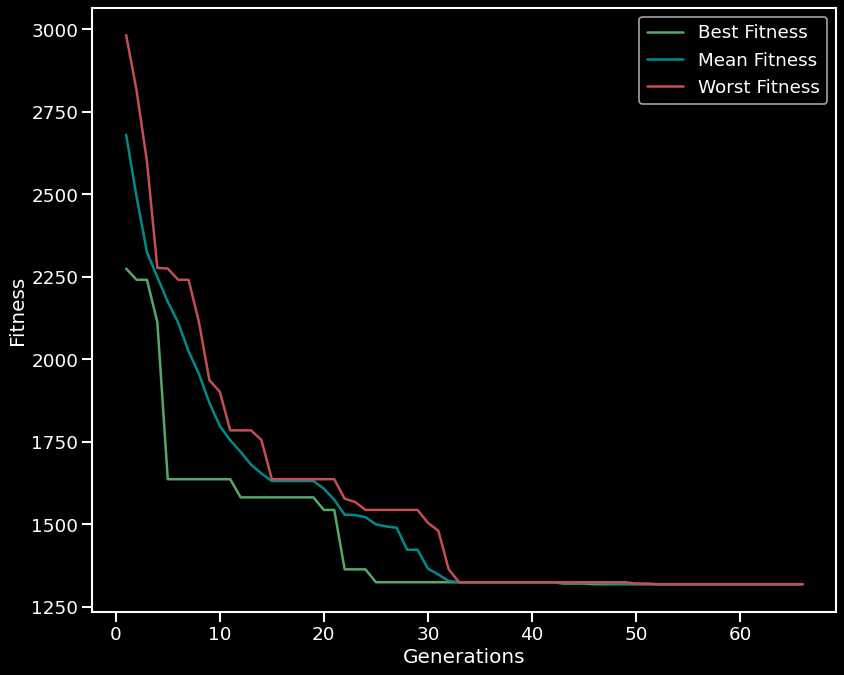

In [ ]:
model = Evolutionary_Algorithm(size_population=10, 
                               prob_mutation=0.8,
                               amount_parents_selection=5, generations=1000, 
                               target_fitness=0, prob_recombination=1.0, mutation='non_uniform',
                               crossover='cut_crossfill', k_crossover=2, k_mutation=8, 
                               max_factor_scramble=0.25, problem='la01')
model.technical_summary()

start_time = time()
model.fit(stop=20, verbose=20)
elapsed_time = time() - start_time
print("\nElapsed time: %.4f seconds." % elapsed_time)

model.summary()
model.history_gen_plot()

## Get metrics of models

In [214]:
data = {'model': [], 'mean_execution_time': [], 'mean_cost': [], 'std': []}
for f in os.listdir('solutions/'):
    if f.startswith('ft06'):
        model_name = f[5:-4]
        if len(model_name) > 0:
            filename = open('solutions/'+f, 'r')
            fitness_line = filename.readline()[1:-2]
            fitness = [int(e.strip()) for e in fitness_line.split(',')]
            et_line = filename.readline()[1:-2]
            et = [float(e.strip()) for e in et_line.split(',')]
            data['model'].append(model_name)
            data['mean_execution_time'].append(sum(et)/len(et))
            data['mean_cost'].append(sum(fitness)/len(fitness))
            data['std'].append(np.std(fitness))
            

df = pd.DataFrame(data)
df.head(26)

model  mean_execution_time  mean_cost       std
0           average_inversion             1.622845  80.166667  0.734091
1               average_kswap             2.263695  78.800000  1.989975
2         average_non_uniform             1.449262  78.466667  2.578544
3            average_scramble             1.288607  80.233333  0.882547
4                average_swap             2.000236  76.866667  2.276449
5             average_uniform             1.221216  78.433333  2.304826
6     cut_crossfill_inversion             2.704157  82.766667  3.051593
7         cut_crossfill_kswap             3.860468  77.600000  2.928026
8   cut_crossfill_non_uniform             1.896363  78.033333  2.892327
9      cut_crossfill_scramble             2.513844  80.933333  3.182592
10         cut_crossfill_swap             3.306992  79.733333  3.405225
11      cut_crossfill_uniform             1.686816  80.900000  2.700000
12              ox1_inversion             2.876472  82.666667  3.379678
13                  ox1_kswap             3.838432  77.800000  2.761642
14            ox1_non_uniform             1.925755  79.266667  2.542090
15               ox1_scramble             2.514678  80.766667  3.422312
16                   ox1_swap             3.423159  79.733333  2.931818
17                ox1_uniform             1.680344  81.666667  2.054805
18                        PSO             6.089716  74.166667  2.634177
19                         SA            14.703152  76.100000  2.992769
20          uniform_inversion             2.803376  81.666667  2.521023
21              uniform_kswap             3.855146  78.233333  2.616401
22        uniform_non_uniform             1.822516  79.100000  3.690980
23           uniform_scramble             2.511909  80.700000  2.979374
24               uniform_swap             3.371381  78.666667  3.399346
25            uniform_uniform             1.634855  79.533333  3.073905

# Plot models

Text(0.5, 1.0, 'Comparison between all models')

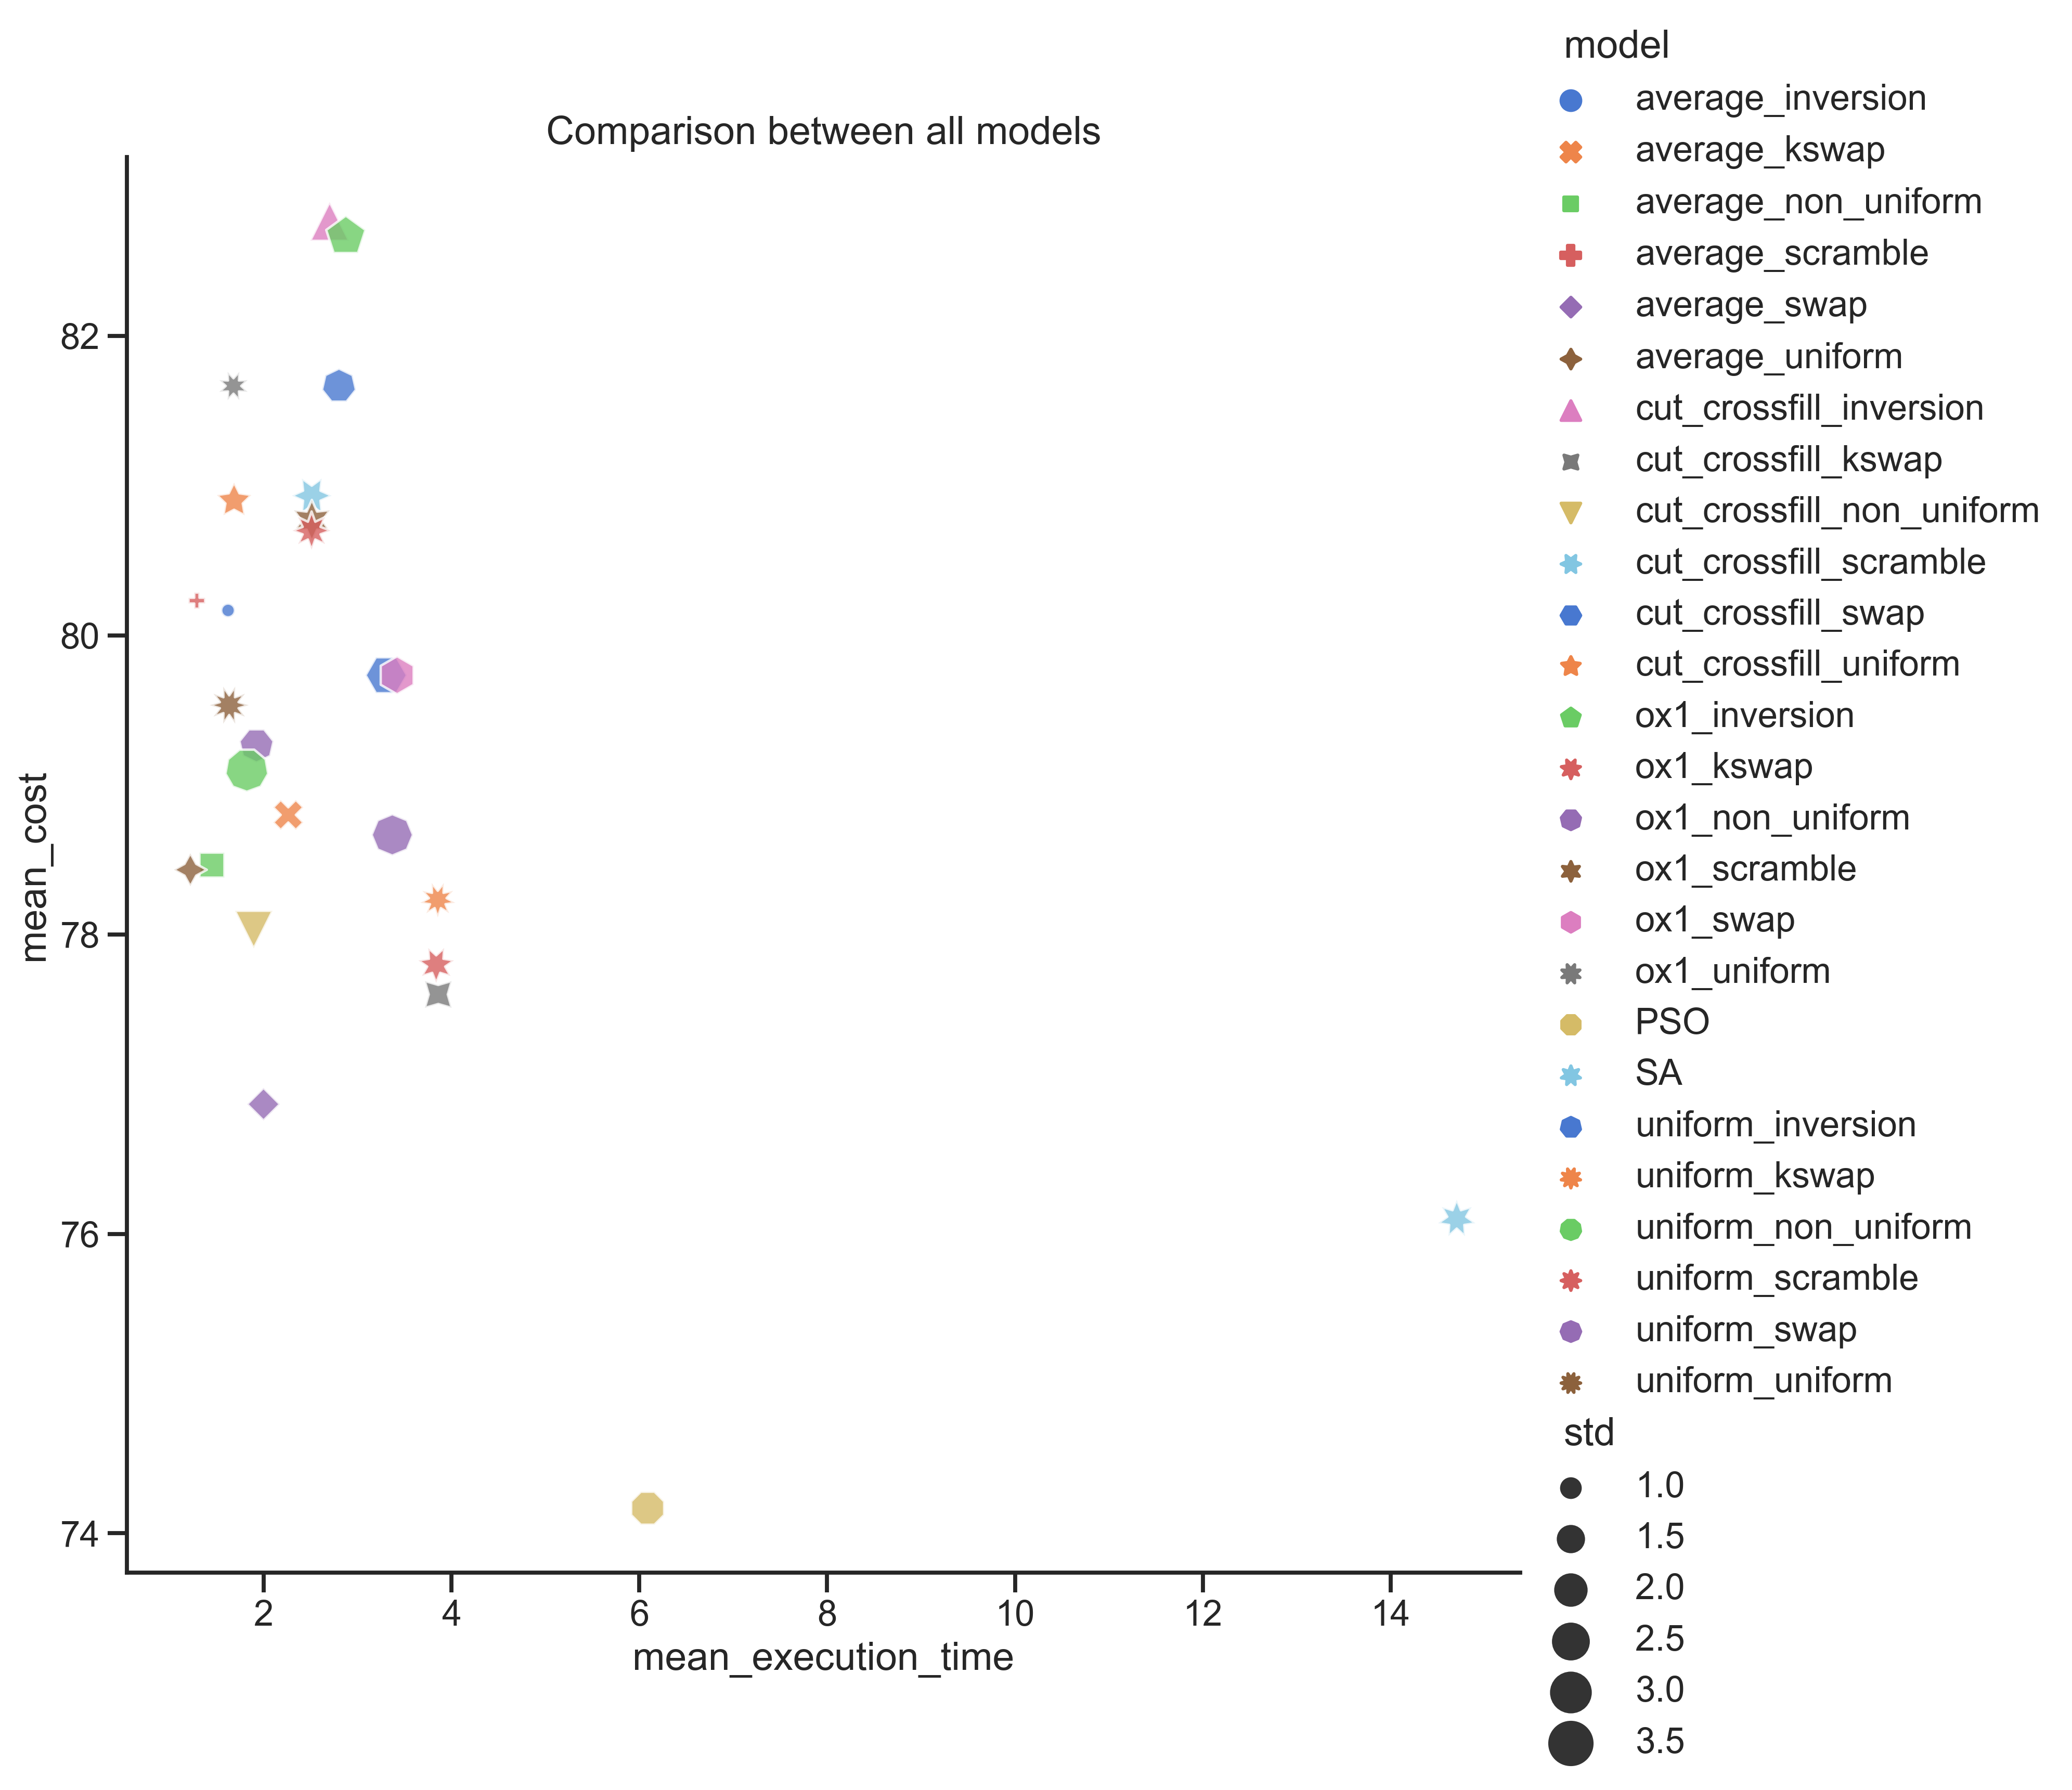

In [216]:
sns.set(style="ticks", context="talk", rc={'figure.figsize':(20,10), 'figure.dpi':300})
sns.relplot(x="mean_execution_time", y="mean_cost", hue="model", size="std", data=df, sizes=(40, 400),
            alpha=.8, palette="muted", height=10, style='model')
plt.title('Comparison between all models')

Text(0.5, 1.0, 'Comparison between all genetic models')

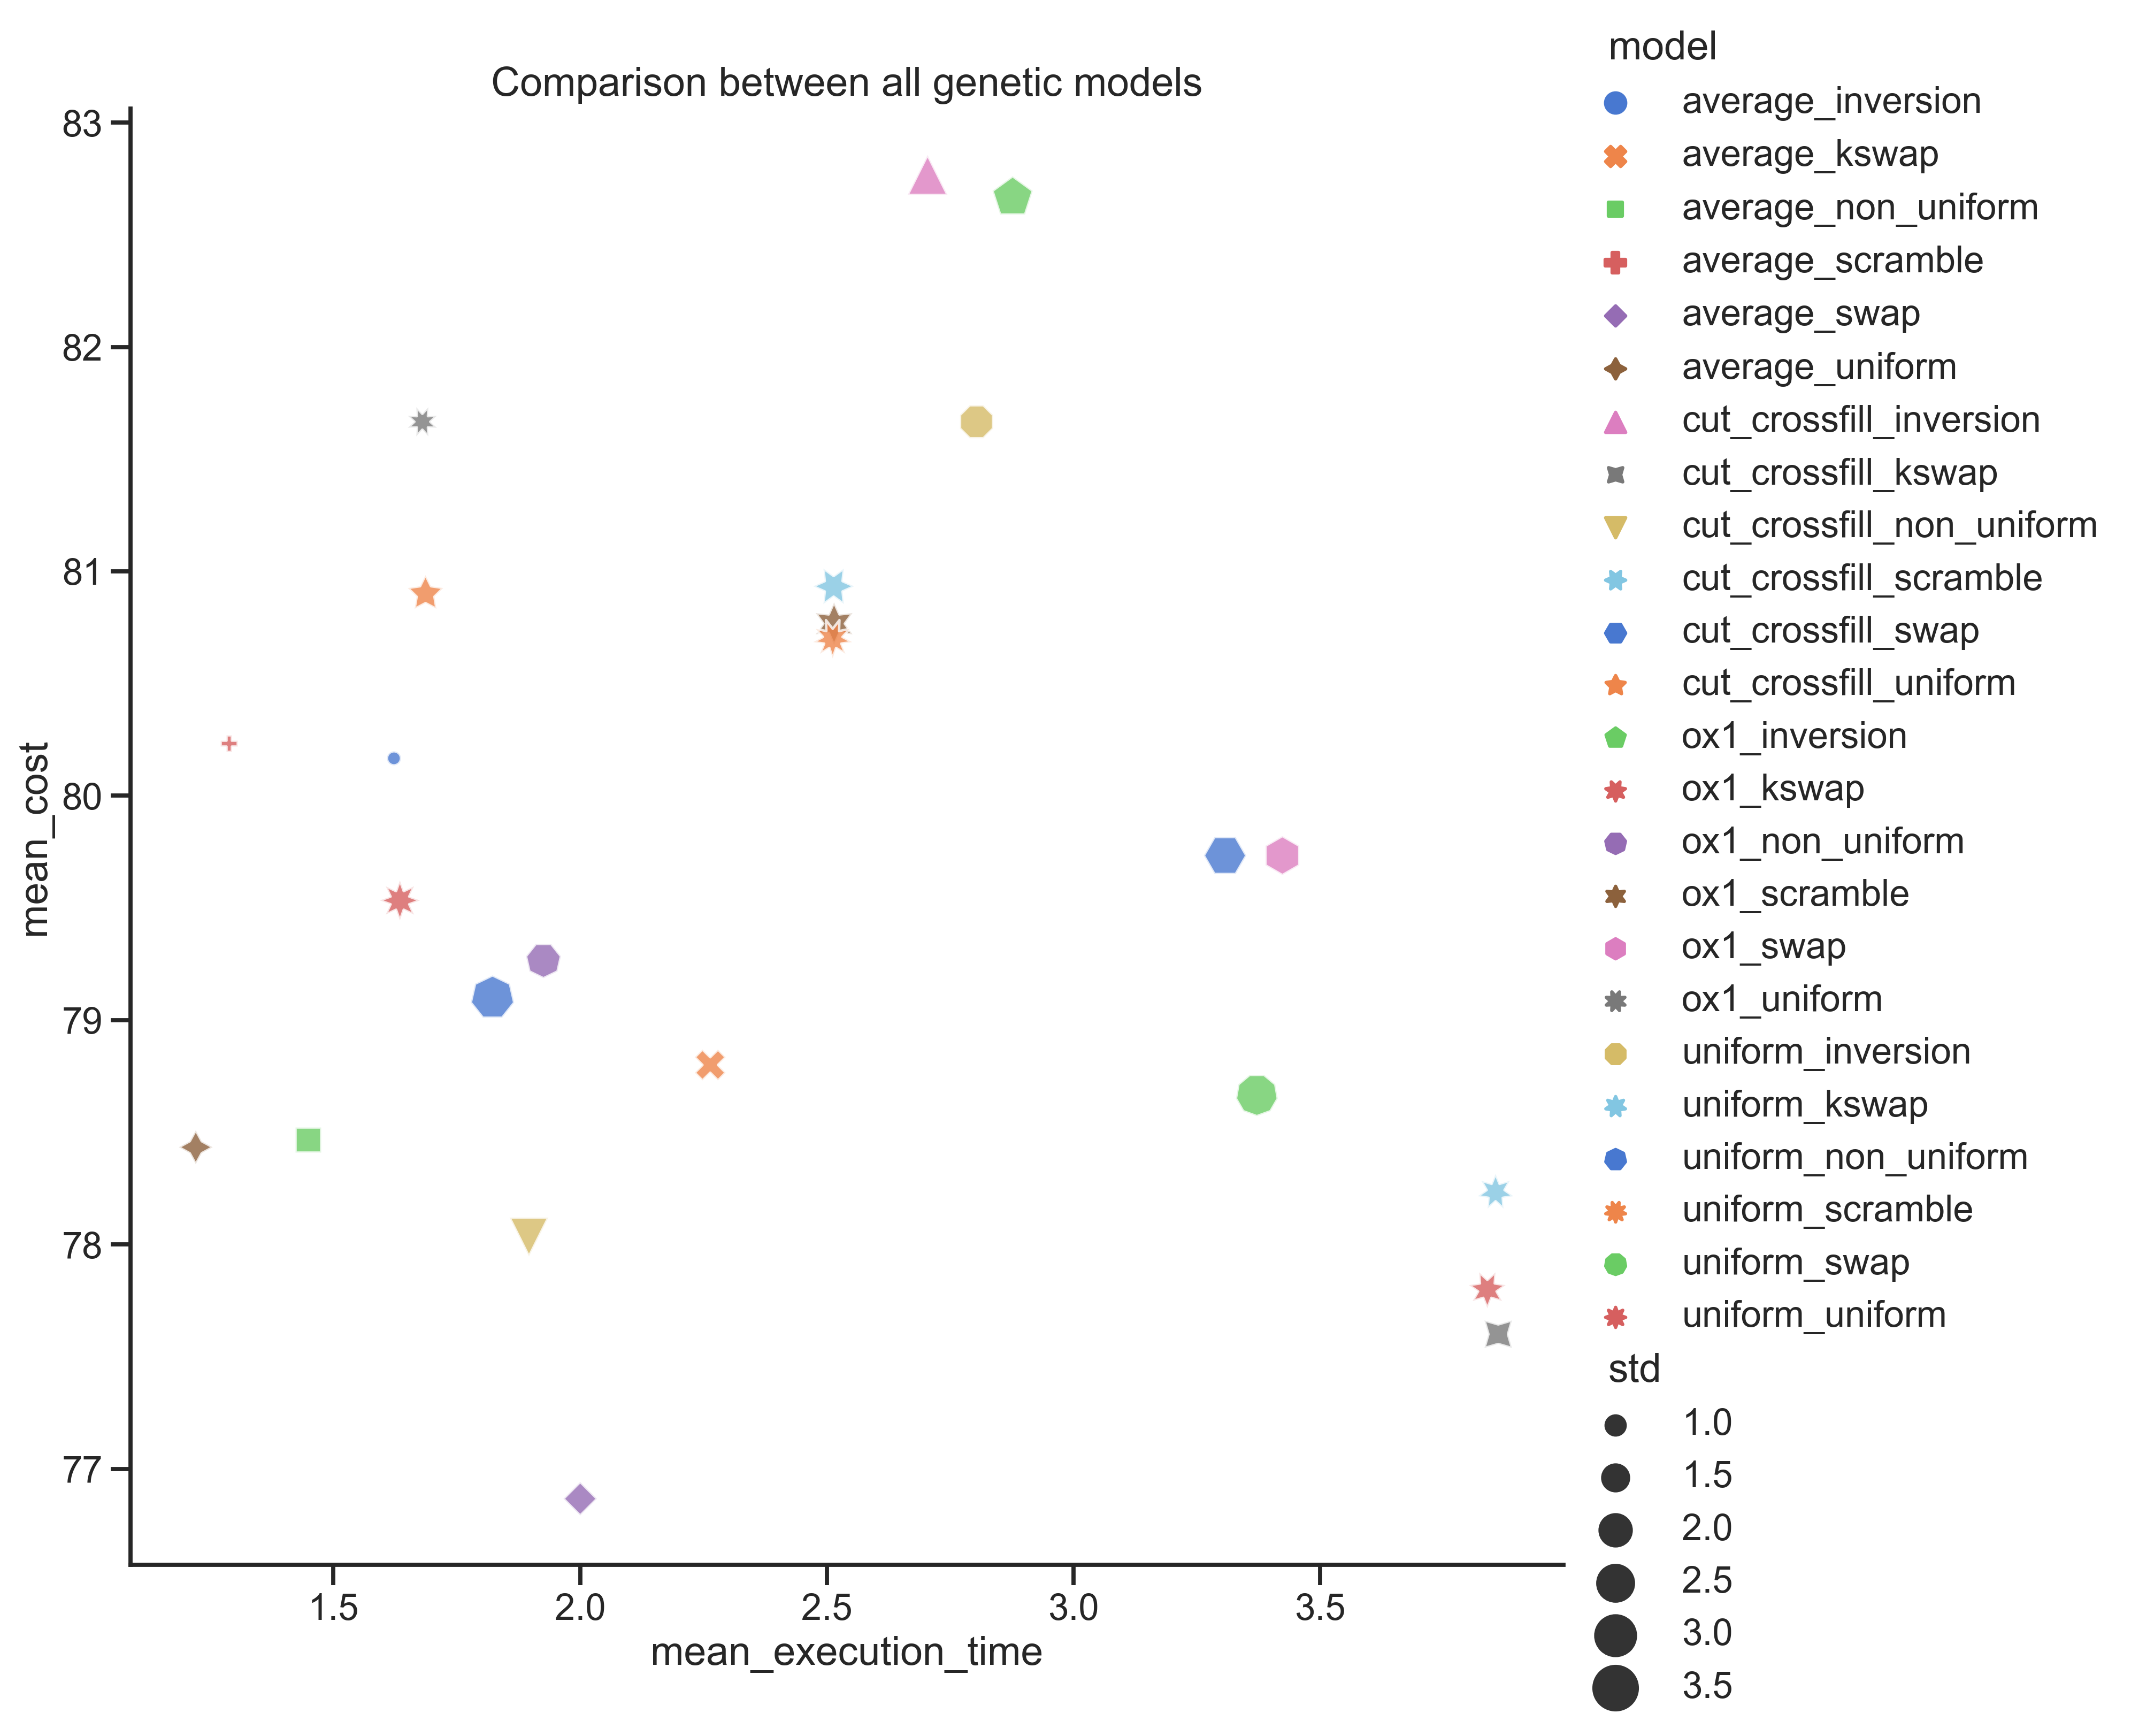

In [217]:
sns.relplot(x="mean_execution_time", y="mean_cost", hue="model", size="std", data=df.drop([18,19]), 
            sizes=(40, 400), alpha=.8, palette="muted", height=10, style='model')
plt.title('Comparison between all genetic models')

In [ ]:
n_runs = 30
models = [('average', 'swap'), ('cut_crossfill', 'kswap'), ('cut_crossfill', 'non_uniform'), 
          ('average','uniform'), ('PSO'), ('SA')]

for problem in os.listdir('problems/'):
    problem = problem[:-4]
    for m in models:
        df = pd.read_csv('runs_data.csv')
        runs_data = df.to_dict()
        k = len(runs_data['model'])
        if m == 'SA' or m == 'PSO':
            model_name = m
        else:
            model_name = m[0] + '-' + m[1]
             
        print('Start', problem, 'this model', model_name)
        for i in range(n_runs):
            if model_name == 'SA':
                model = Simulated_Annealing_Algorithm(init_temp=40, T_factor=0.2, k=50, 
                                                      problem=problem, file_path='problems/')
            elif model_name == 'PSO':
                model = PSO(n_particles=100, iters=100, problem=problem, file_path='problems/')
            else:
                model = Evolutionary_Algorithm(size_population=100, 
                                    prob_mutation=0.8,
                                    amount_parents_selection=5, generations=100, 
                                    target_fitness=0, prob_recombination=1.0, mutation=m[1],
                                    crossover=m[0], k_crossover=0.33, k_mutation=0.33, 
                                    max_factor_scramble=0.33, problem=problem, file_path='problems/')
            
            start_time = time()
            model.fit(stop=100)
            elapsed_time = time() - start_time
            cost, solution = model.get_best()
            runs_data['model'][k] = model_name
            runs_data['problem'][k] = problem
            runs_data['cost'][k] = cost
            runs_data['time'][k] = elapsed_time
            runs_data['solution'][k] = solution
            
            df = pd.DataFrame(runs_data)
            df.to_csv('runs_data.csv', index=False)
            
            if (i+1) % 10 == 0:
                print(i+1)
                
            k += 1
                
        print('Finish for problem', problem, 'this model', model_name)

In [218]:
df = pd.read_csv('runs_data.csv')
print(df.shape)
df.head()

(1440, 5)


model problem  cost      time                 solution
0  average-swap    ft06    74  2.173369   [0, 16, 16, 37, 3, 44]
1  average-swap    ft06    80  2.250934  [54, 12, 14, 35, 0, 44]
2  average-swap    ft06    77  1.973196   [0, 16, 17, 38, 3, 47]
3  average-swap    ft06    80  1.844085  [54, 12, 14, 35, 0, 44]
4  average-swap    ft06    80  1.885120  [54, 12, 14, 35, 0, 43]

In [230]:
reference_cost = {'ft06':73, 'la01': 971, 'la02': 937, 'la03': 820, 'la04': 887, 'la05': 777, 
                  'la10': 1287, 'la20': 1526}
problems = df['problem'].unique()
models = df['model'].unique()
data = {'model': [], 'problem':[], 'best': [], 'mean_cost': [], 'std_cost':[], 'mean_time': [], 'std_time': [], 
        'ARPD': [], 'RPD': []}
for problem in problems:
    filter_problem_df = df[df['problem'] == problem]
    for model in models:
        filter_model_df = filter_problem_df[filter_problem_df['model'] == model]
        cost = filter_model_df['cost']
        time = filter_model_df['time']
        data['model'].append(model)
        data['problem'].append(problem)
        data['best'].append(min(cost))
        data['mean_cost'].append(np.mean(cost))
        data['std_cost'].append(np.std(cost))
        data['mean_time'].append(np.mean(time))
        data['std_time'].append(np.std(time))
        data['ARPD'].append((data['mean_cost'][-1] - reference_cost[problem])/reference_cost[problem]*100)
        data['RPD'].append((min(cost) - reference_cost[problem])/reference_cost[problem]*100)
results_df = pd.DataFrame(data)
results_df.to_csv('results_data.csv', index=False)

In [236]:
results_df.head()

model problem  best  mean_cost  std_cost  mean_time  \
0               average-swap    ft06    74  78.233333  2.390026   2.016650   
1        cut_crossfill-kswap    ft06    74  78.700000  2.672702   3.931028   
2  cut_crossfill-non_uniform    ft06    74  79.666667  3.123388   1.925938   
3            average-uniform    ft06    74  79.100000  2.165641   1.144033   
4                        PSO    ft06    73  74.000000  2.463060   6.038288   

   std_time      ARPD       RPD  
0  0.147711  7.168950  1.369863  
1  0.179663  7.808219  1.369863  
2  0.164796  9.132420  1.369863  
3  0.155803  8.356164  1.369863  
4  0.880687  1.369863  0.000000

Text(0.5, 1.0, 'Mean and std of execution time for ft06')

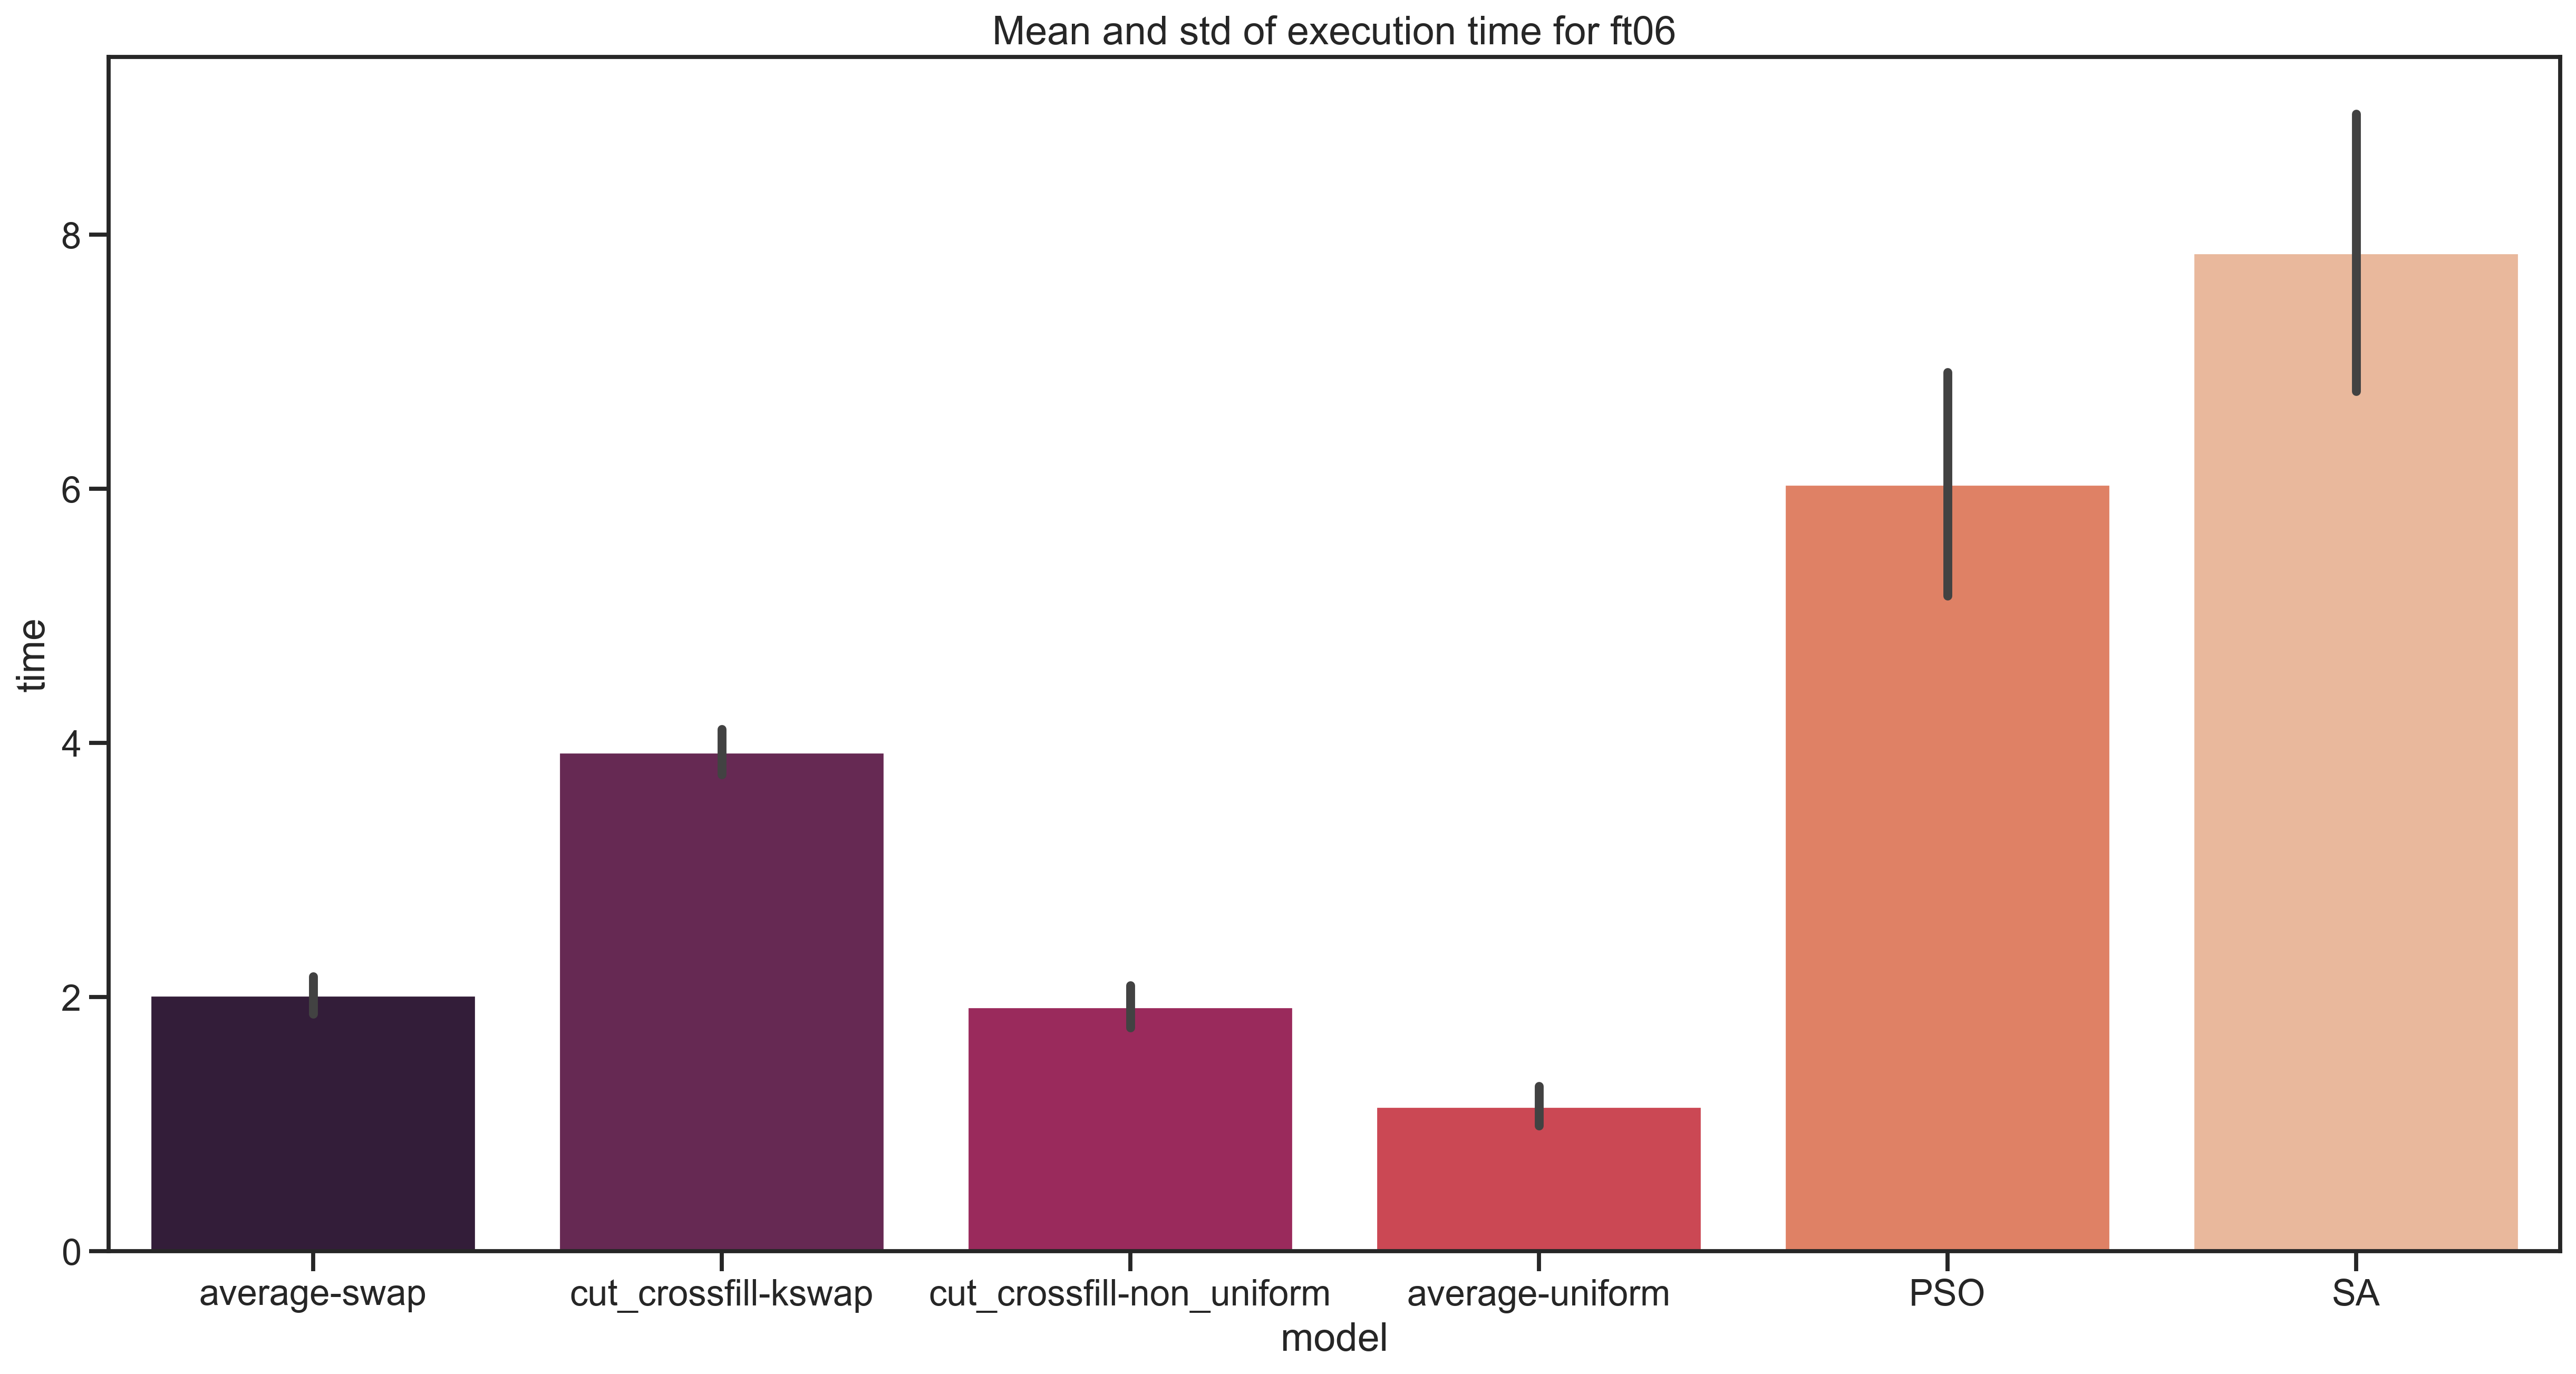

In [220]:
sns.barplot(x='model', y='time', data=df[df['problem'] == 'ft06'], 
            palette='rocket', ci='sd')
plt.title('Mean and std of execution time for ft06')

Text(0.5, 1.0, 'Mean and std of execution time for la10')

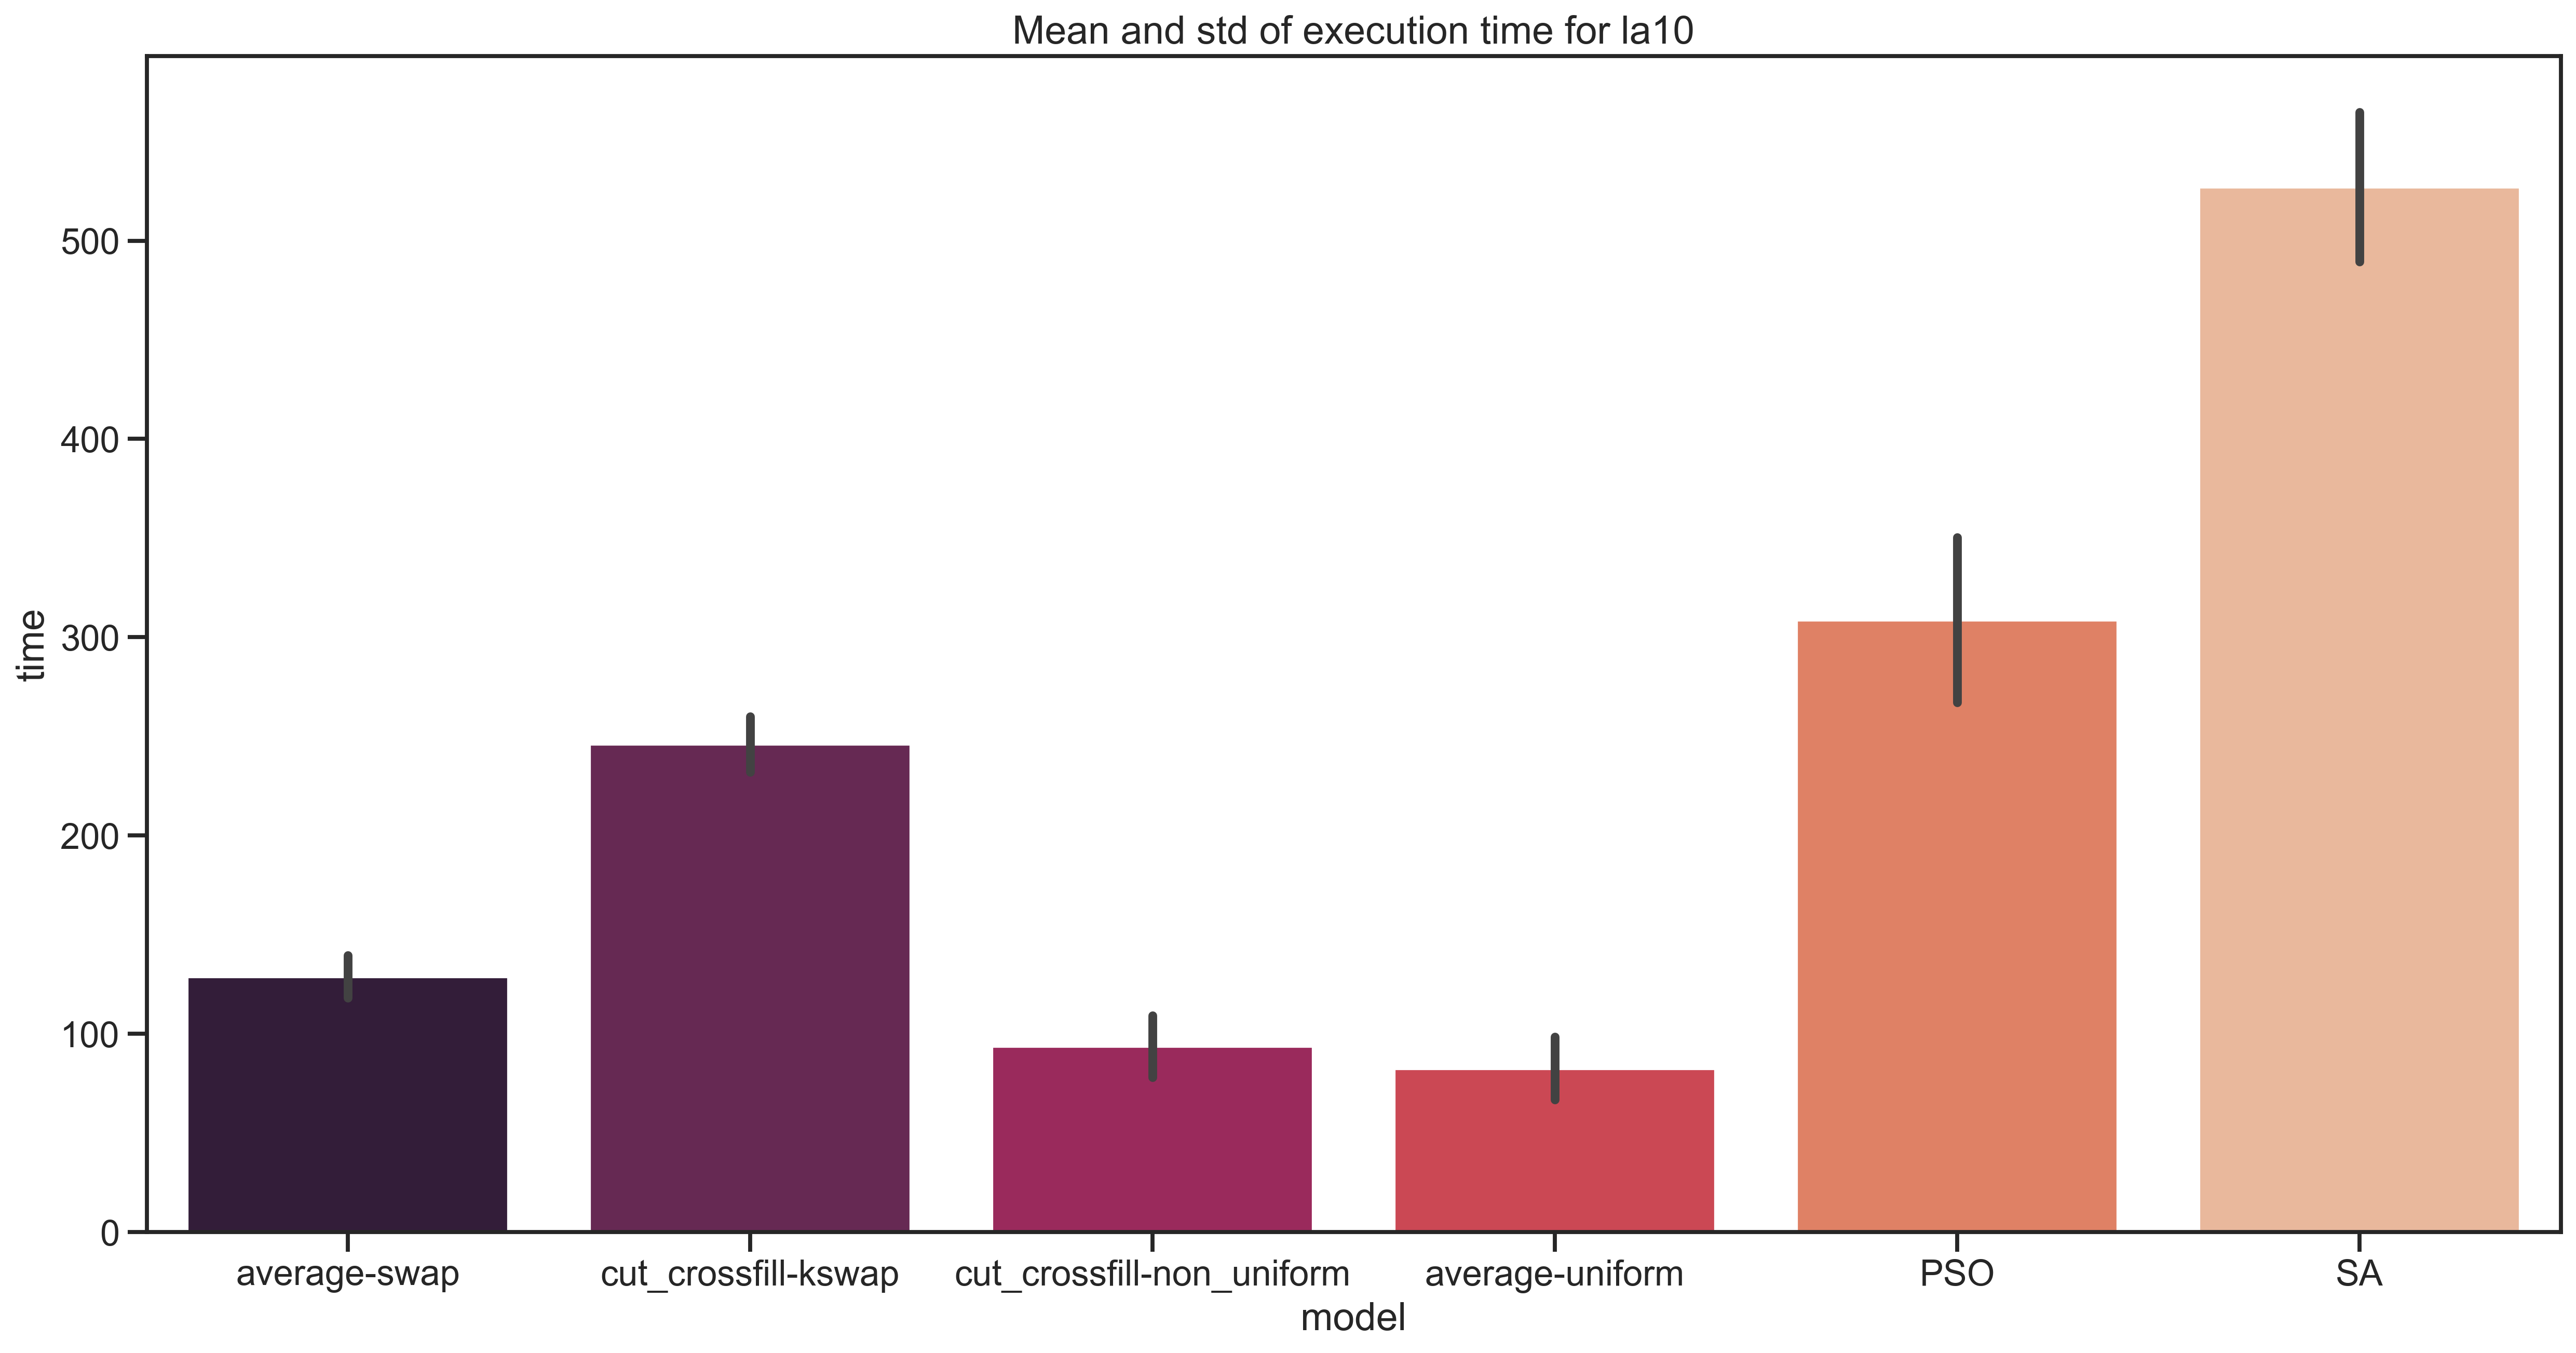

In [221]:
sns.barplot(x='model', y='time', data=df[df['problem'] == 'la10'], 
            palette='rocket', ci='sd')
plt.title('Mean and std of execution time for la10')

Text(0.5, 1.0, 'Mean and std of execution time for la20')

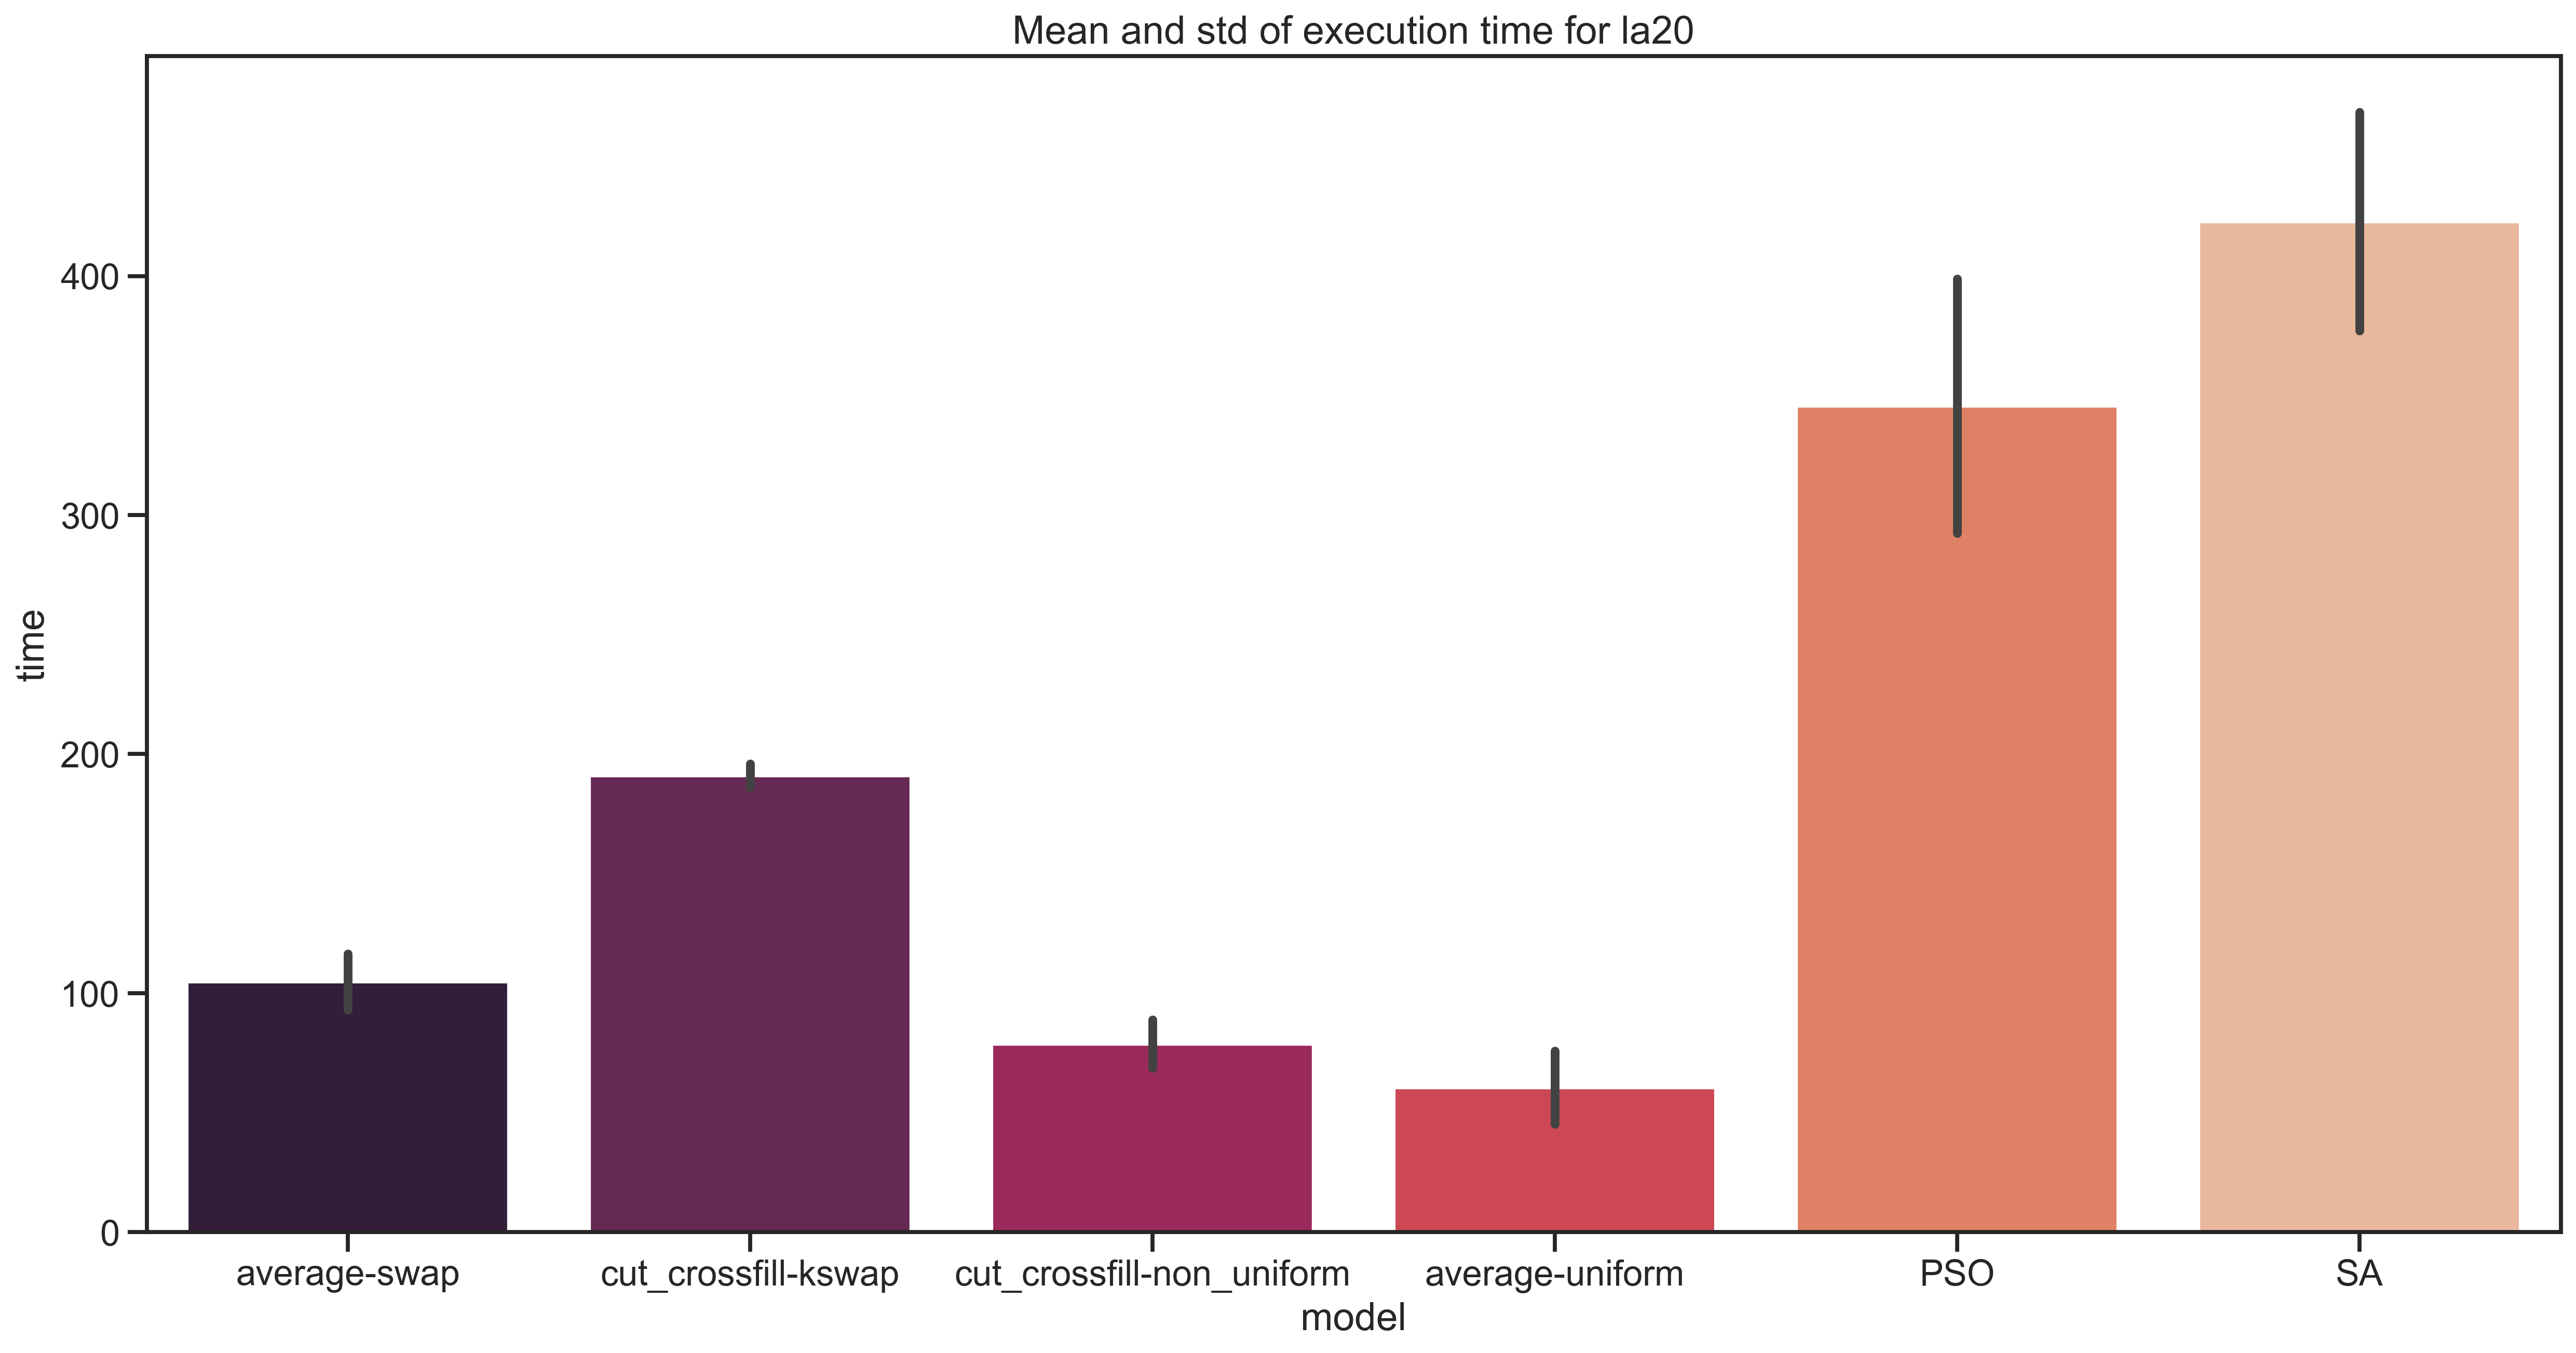

In [222]:
sns.barplot(x='model', y='time', data=df[df['problem'] == 'la20'], 
            palette='rocket', ci='sd')
plt.title('Mean and std of execution time for la20')

Text(0.5, 1.0, 'ARPD for ft06')

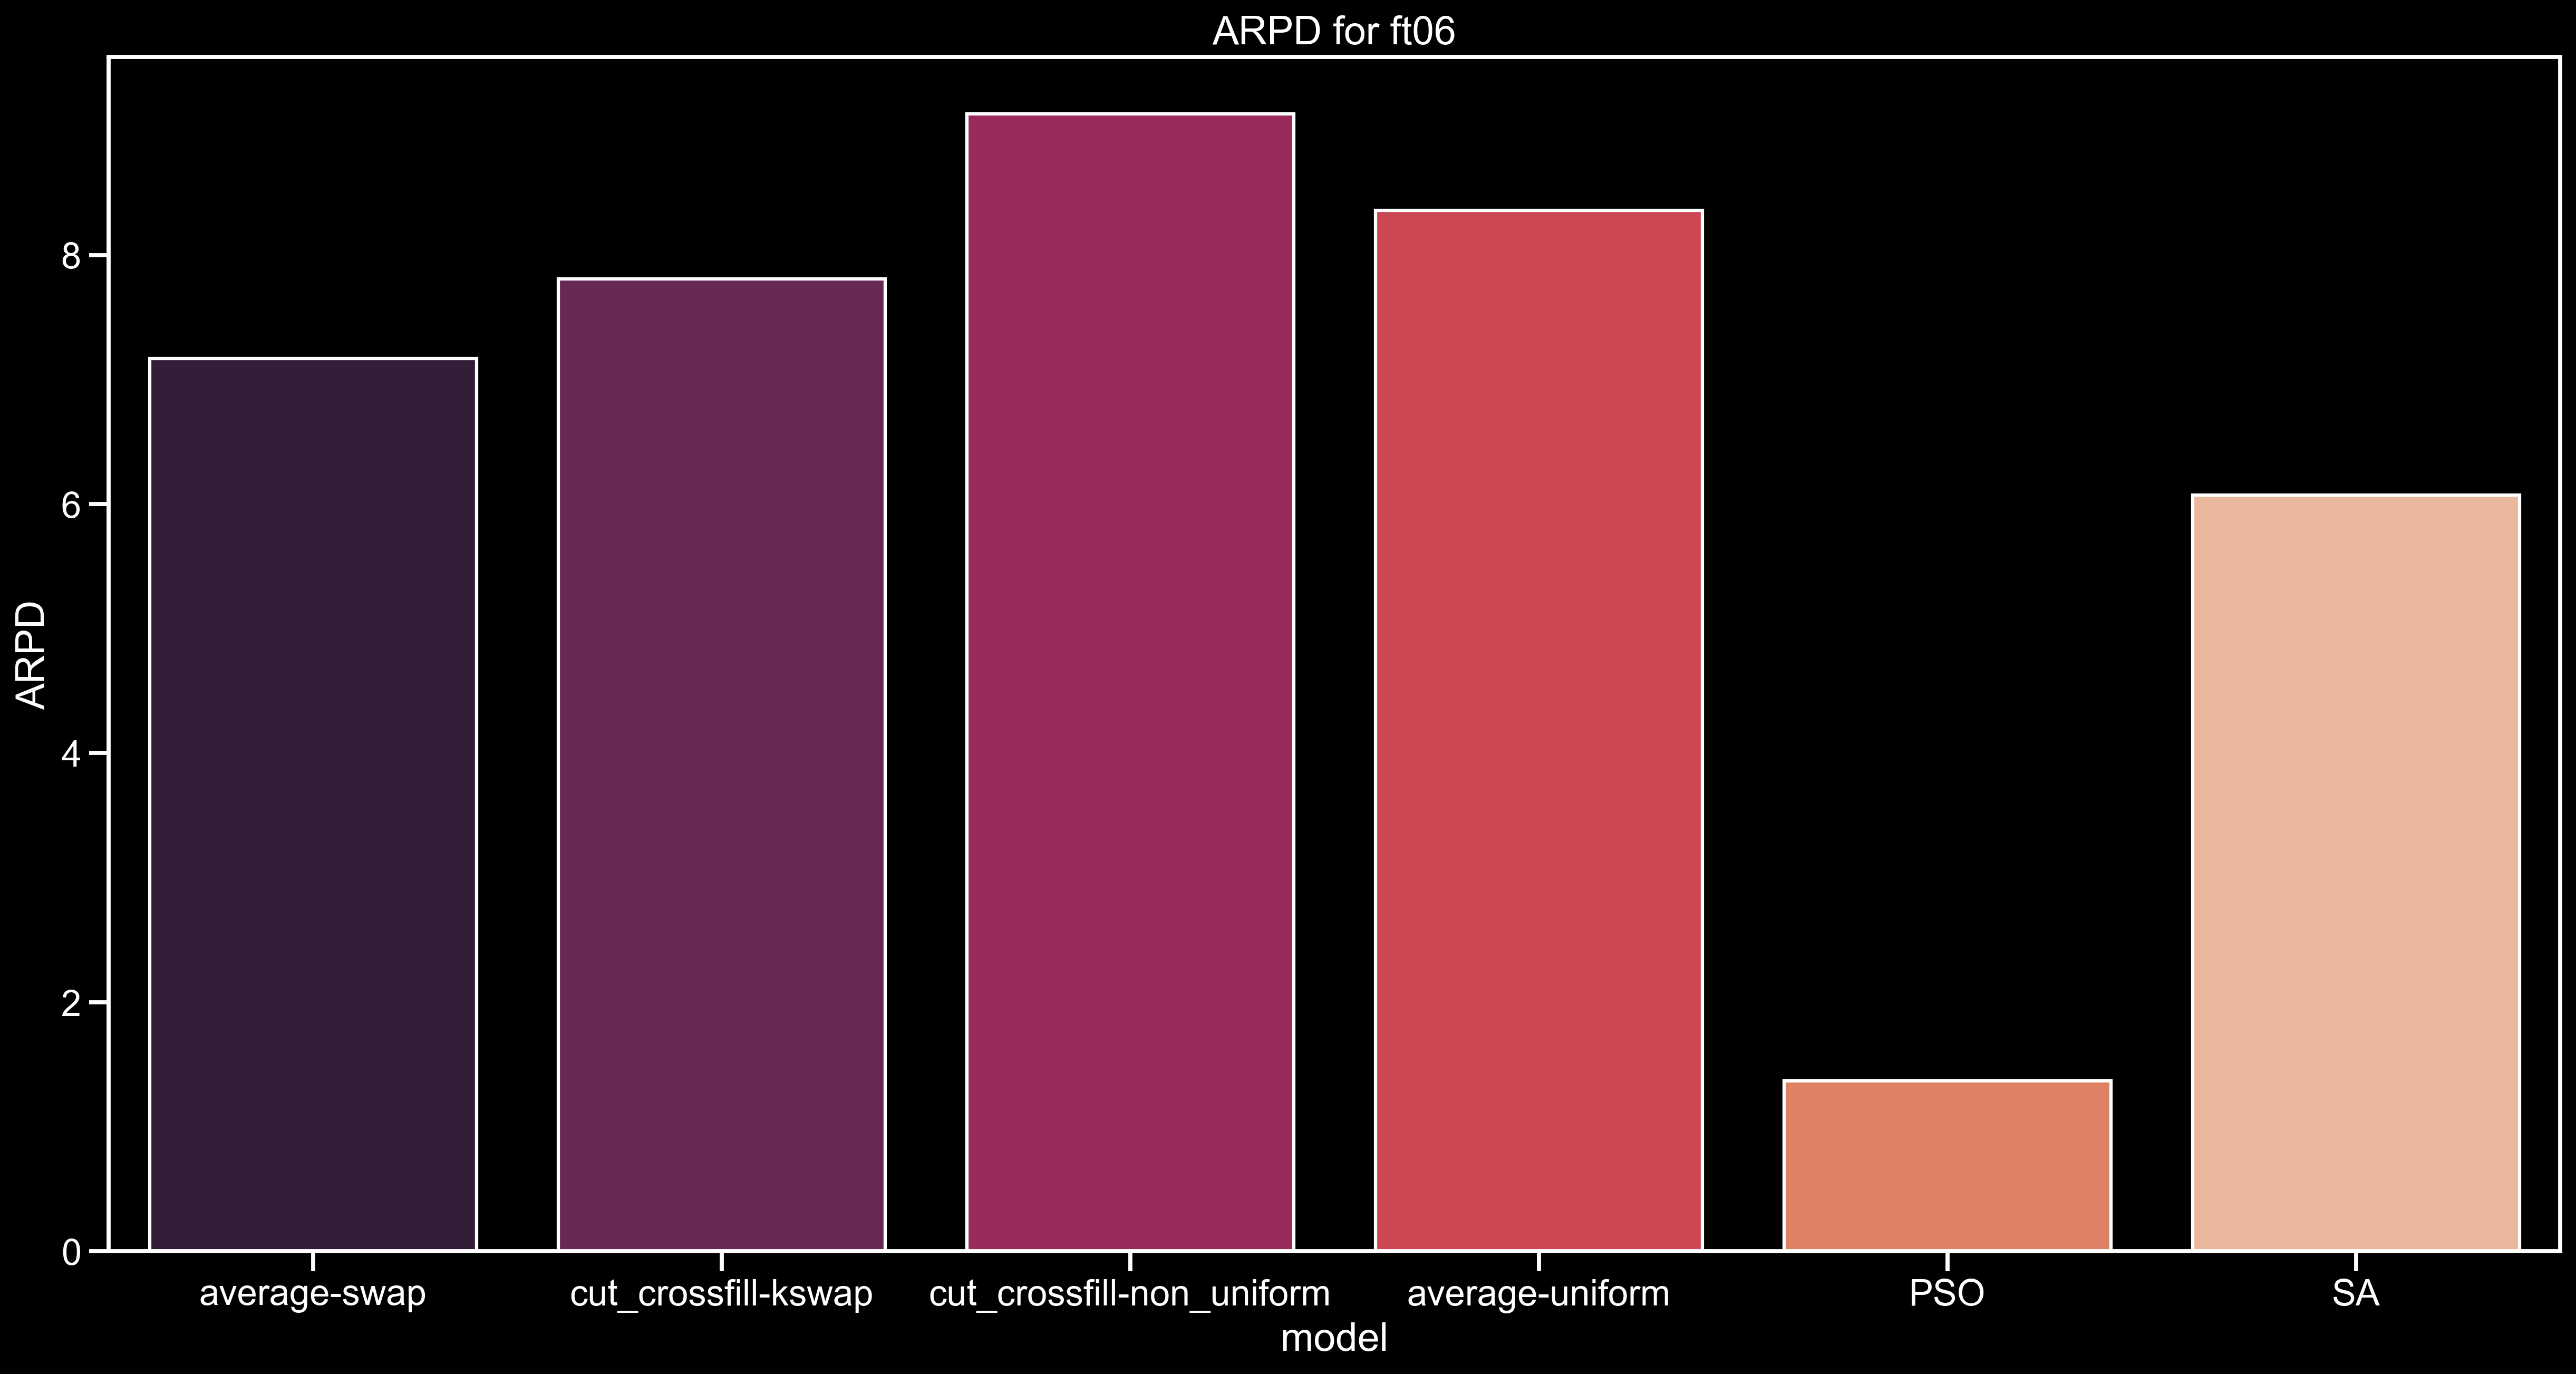

In [189]:
sns.barplot(x='model', y='ARPD', data=results_df[results_df['problem'] == 'ft06'], 
            palette='rocket')
plt.title('ARPD for ft06')

Text(0.5, 1.0, 'ARPD for la10')

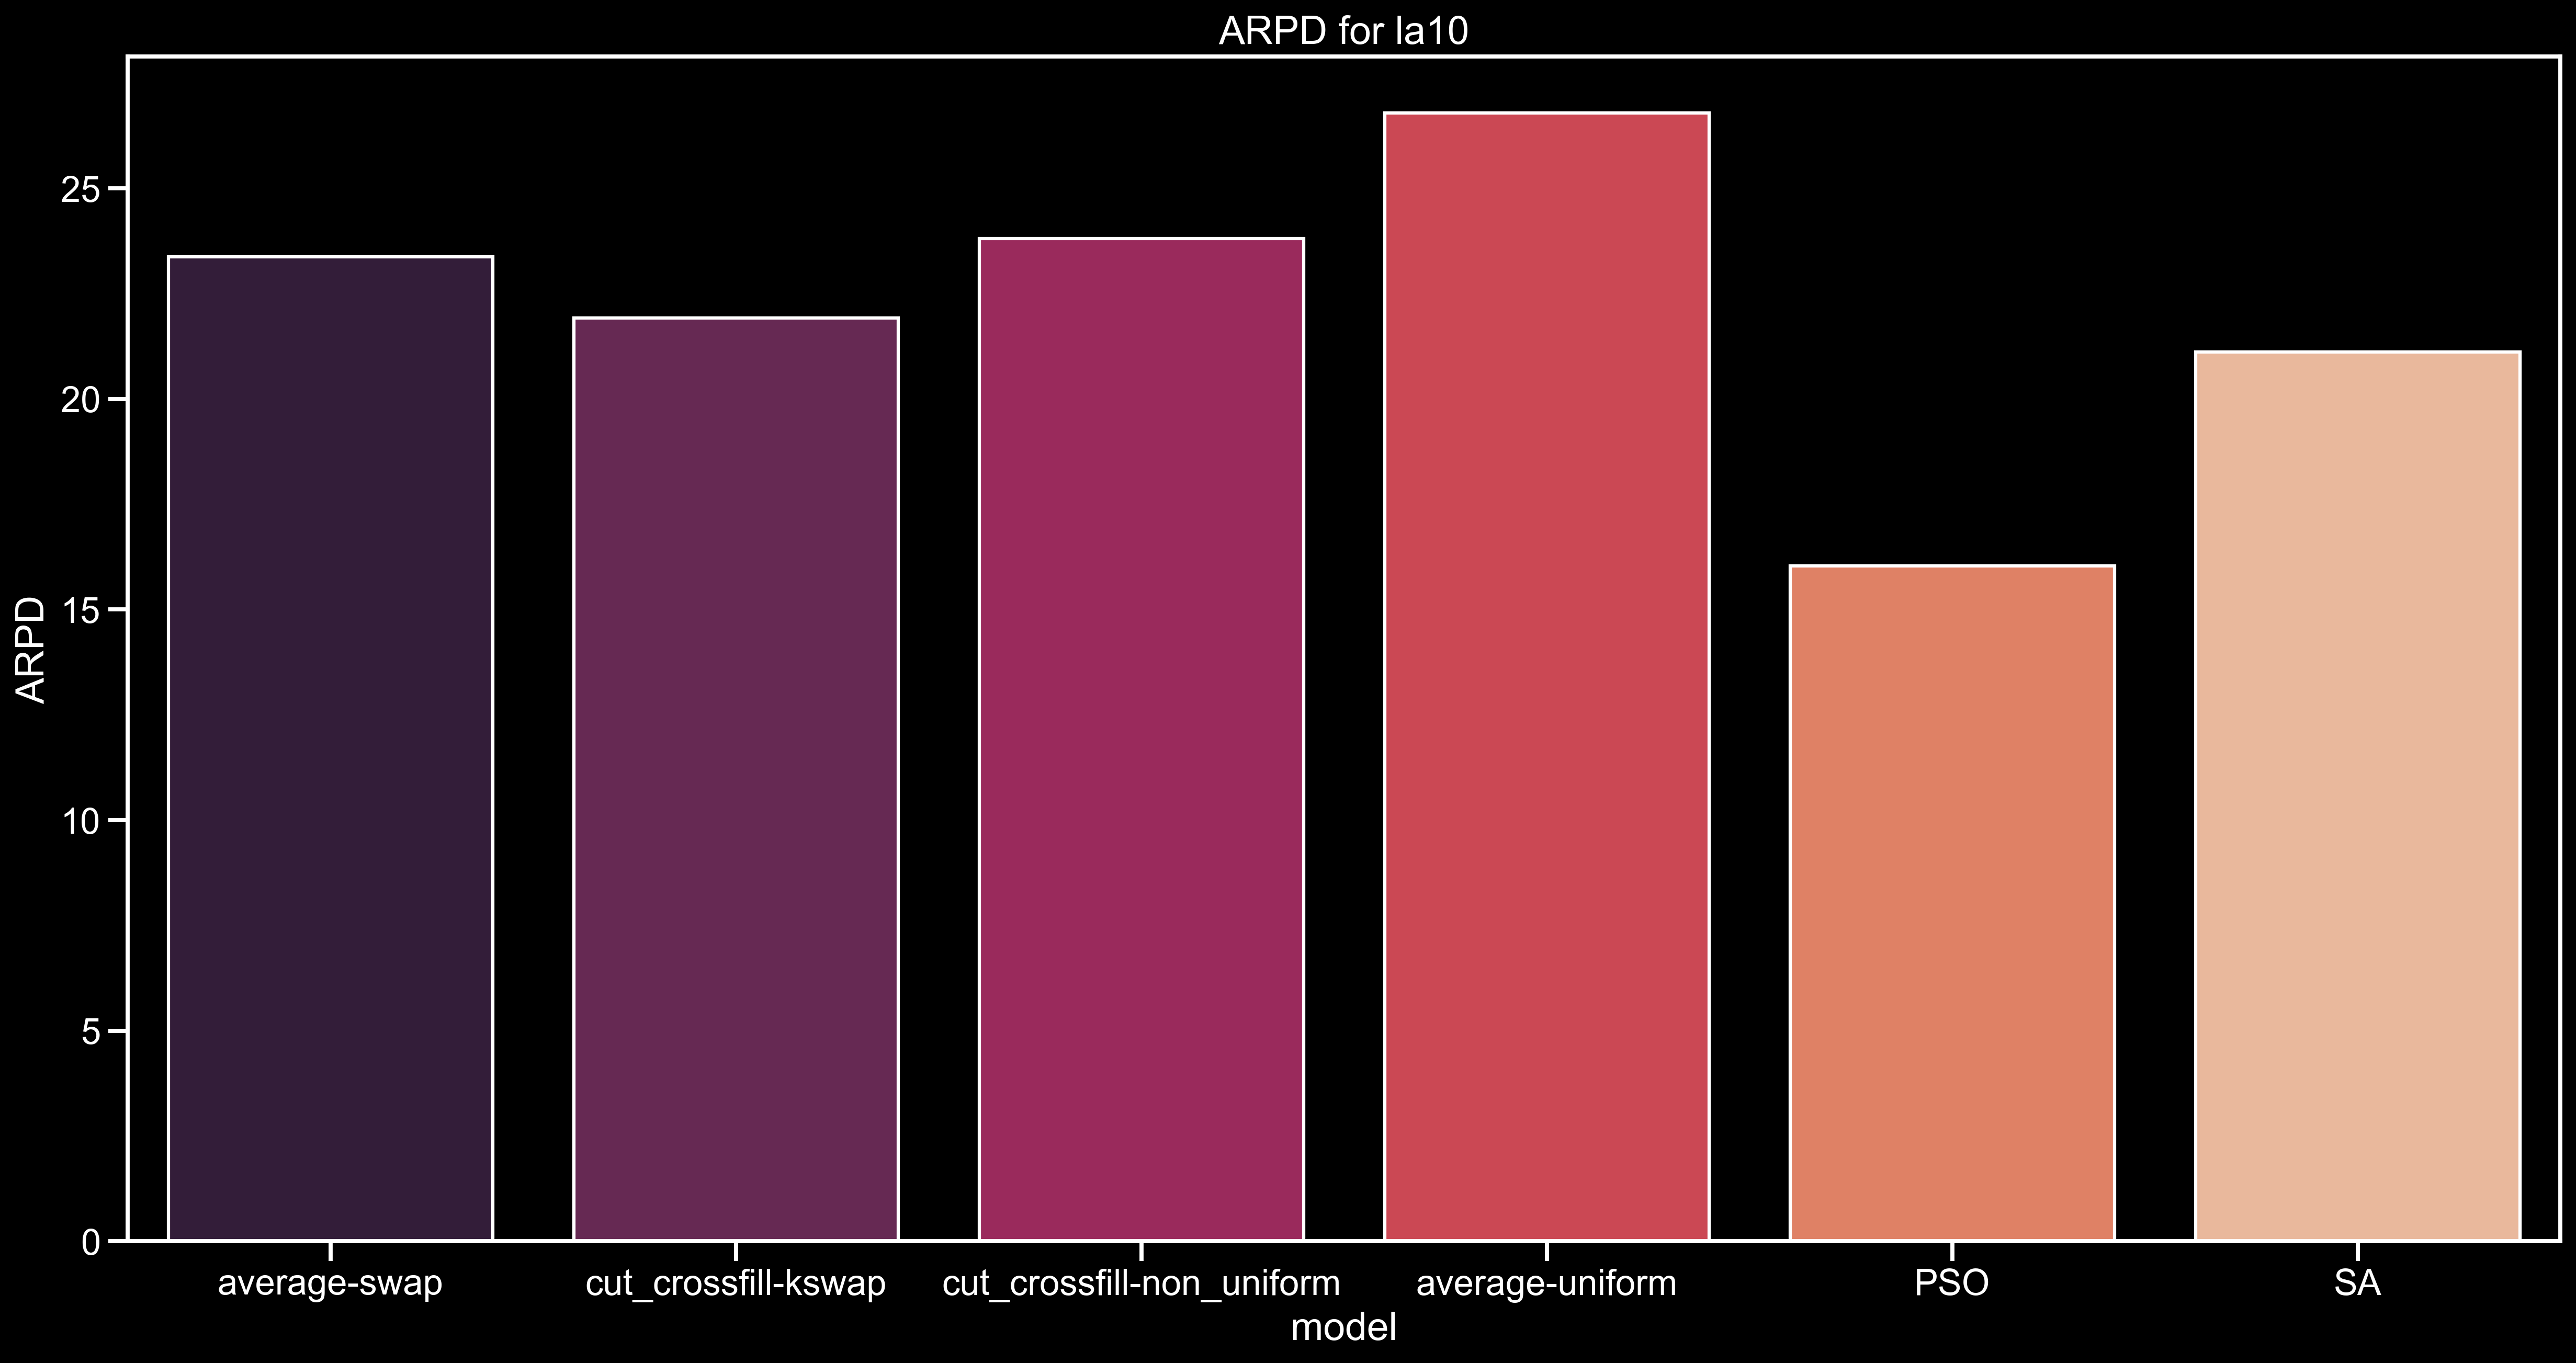

In [190]:
sns.barplot(x='model', y='ARPD', data=results_df[results_df['problem'] == 'la10'], 
            palette='rocket')
plt.title('ARPD for la10')

Text(0.5, 1.0, 'ARPD for la20')

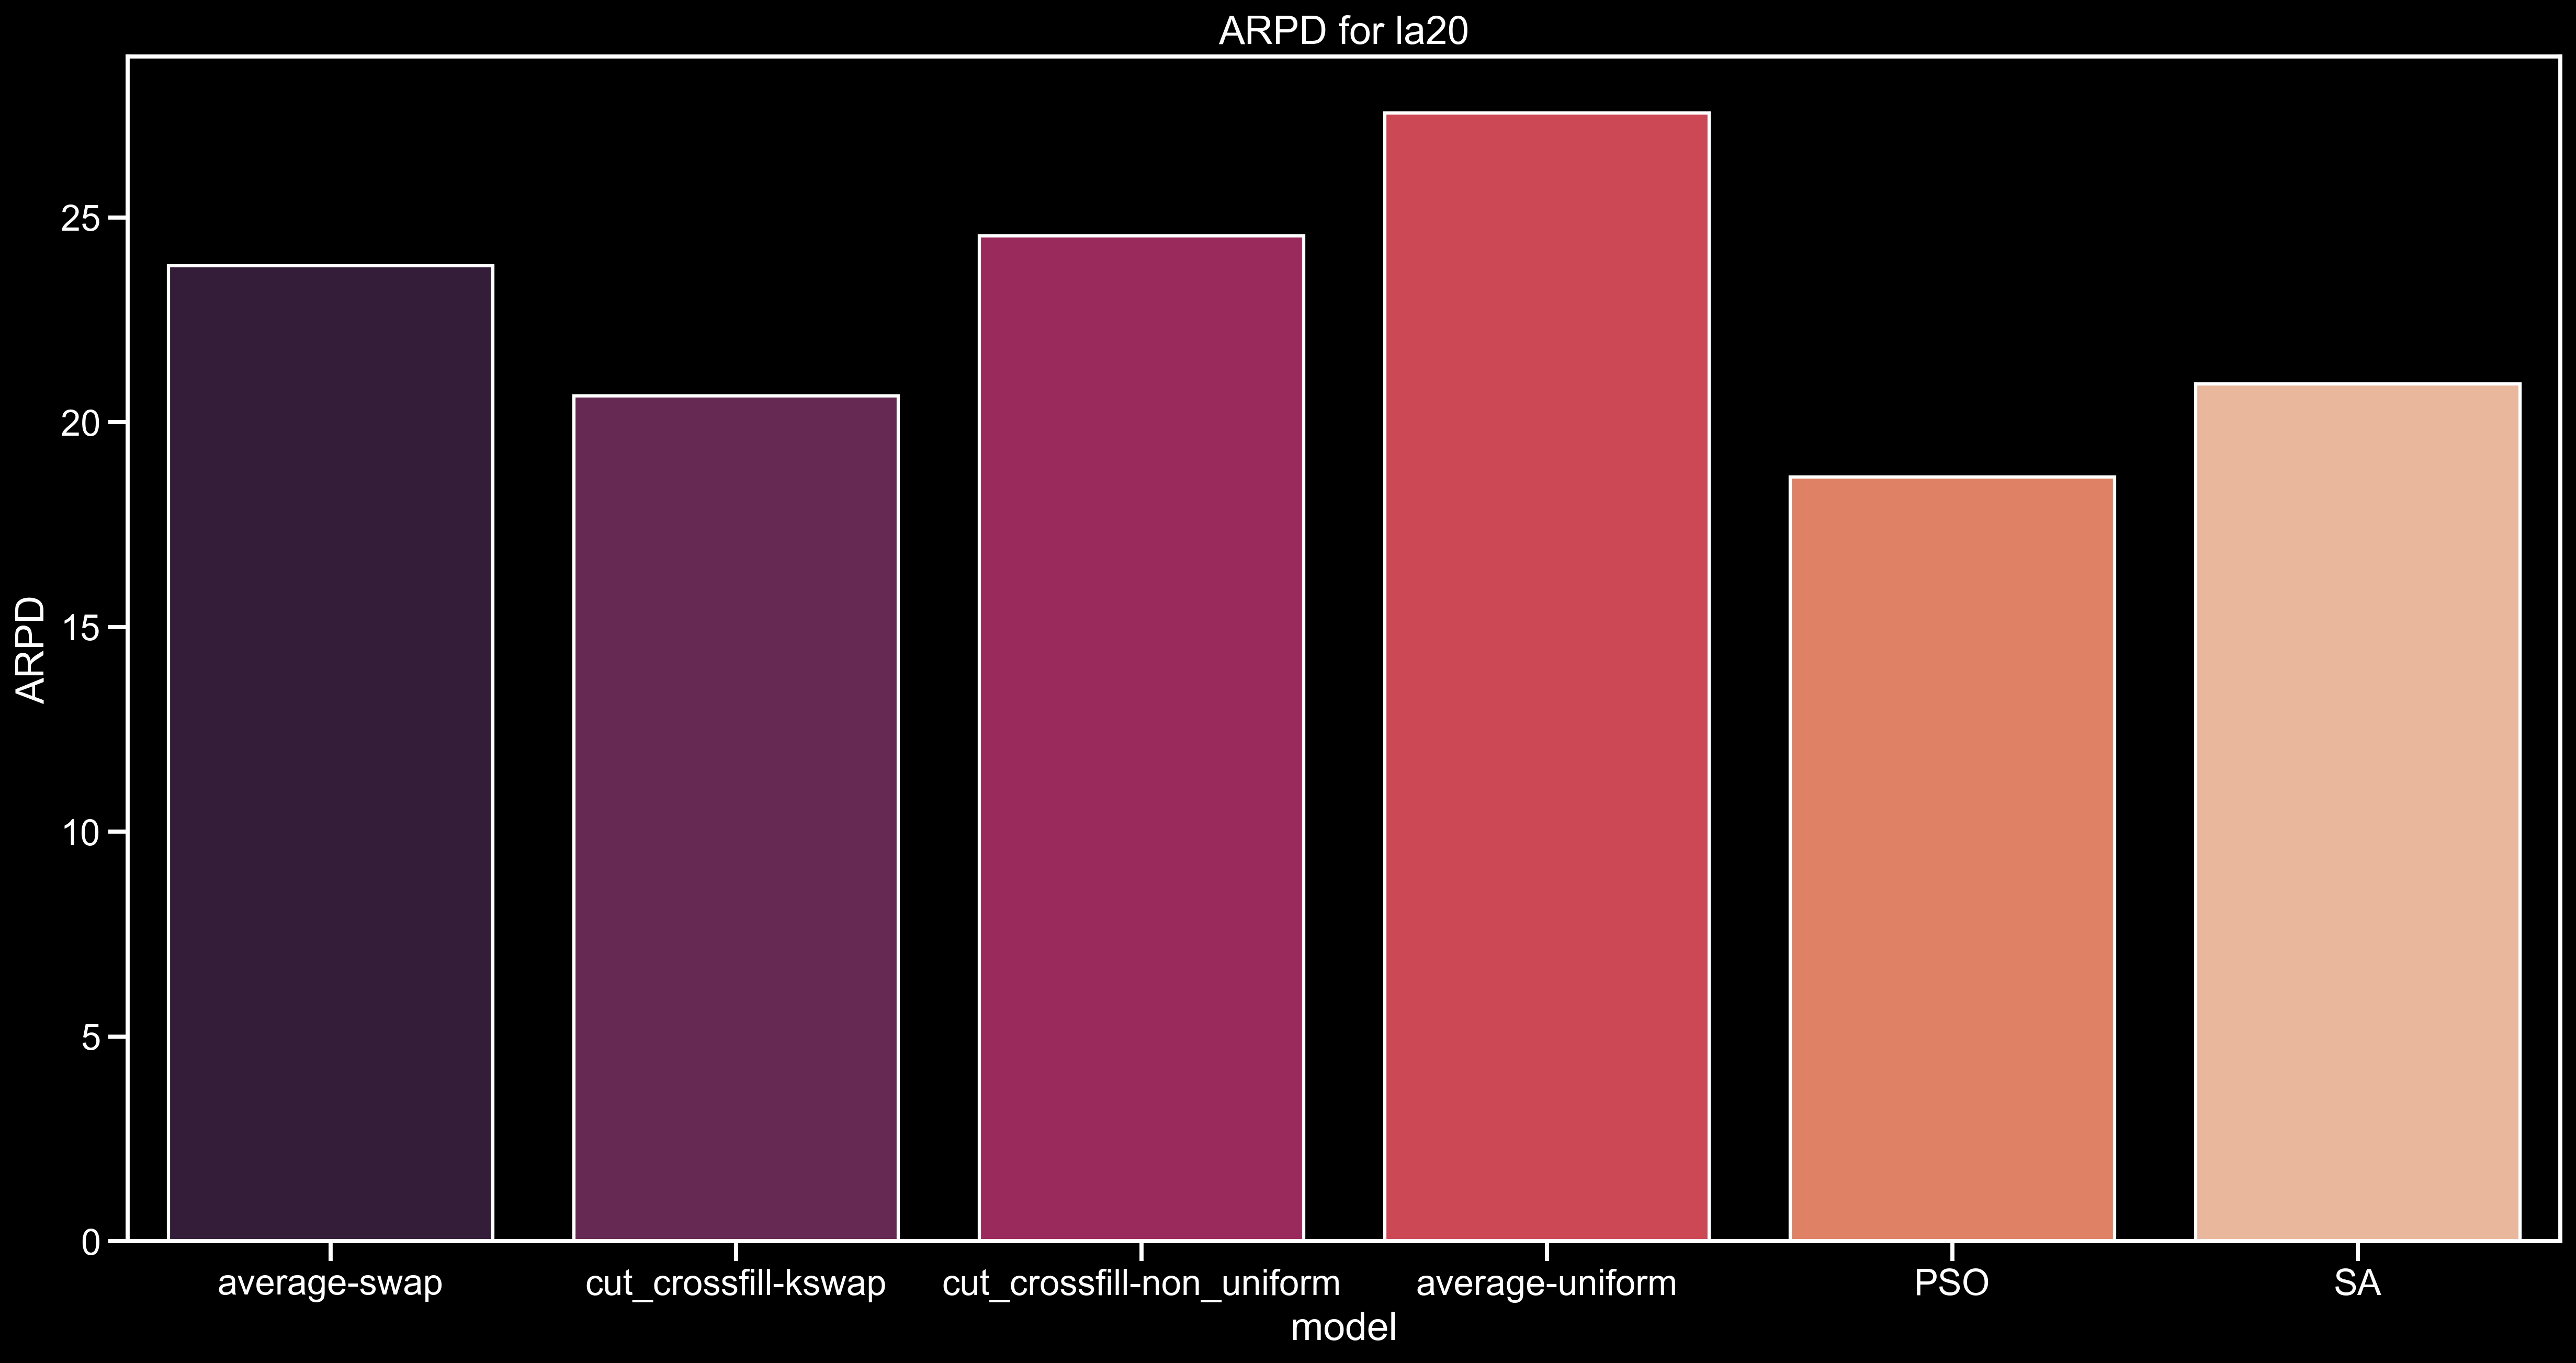

In [191]:
sns.barplot(x='model', y='ARPD', data=results_df[results_df['problem'] == 'la20'], 
            palette='rocket')
plt.title('ARPD for la20')

Text(0.5, 1.0, 'Comparison between all models for ft06')

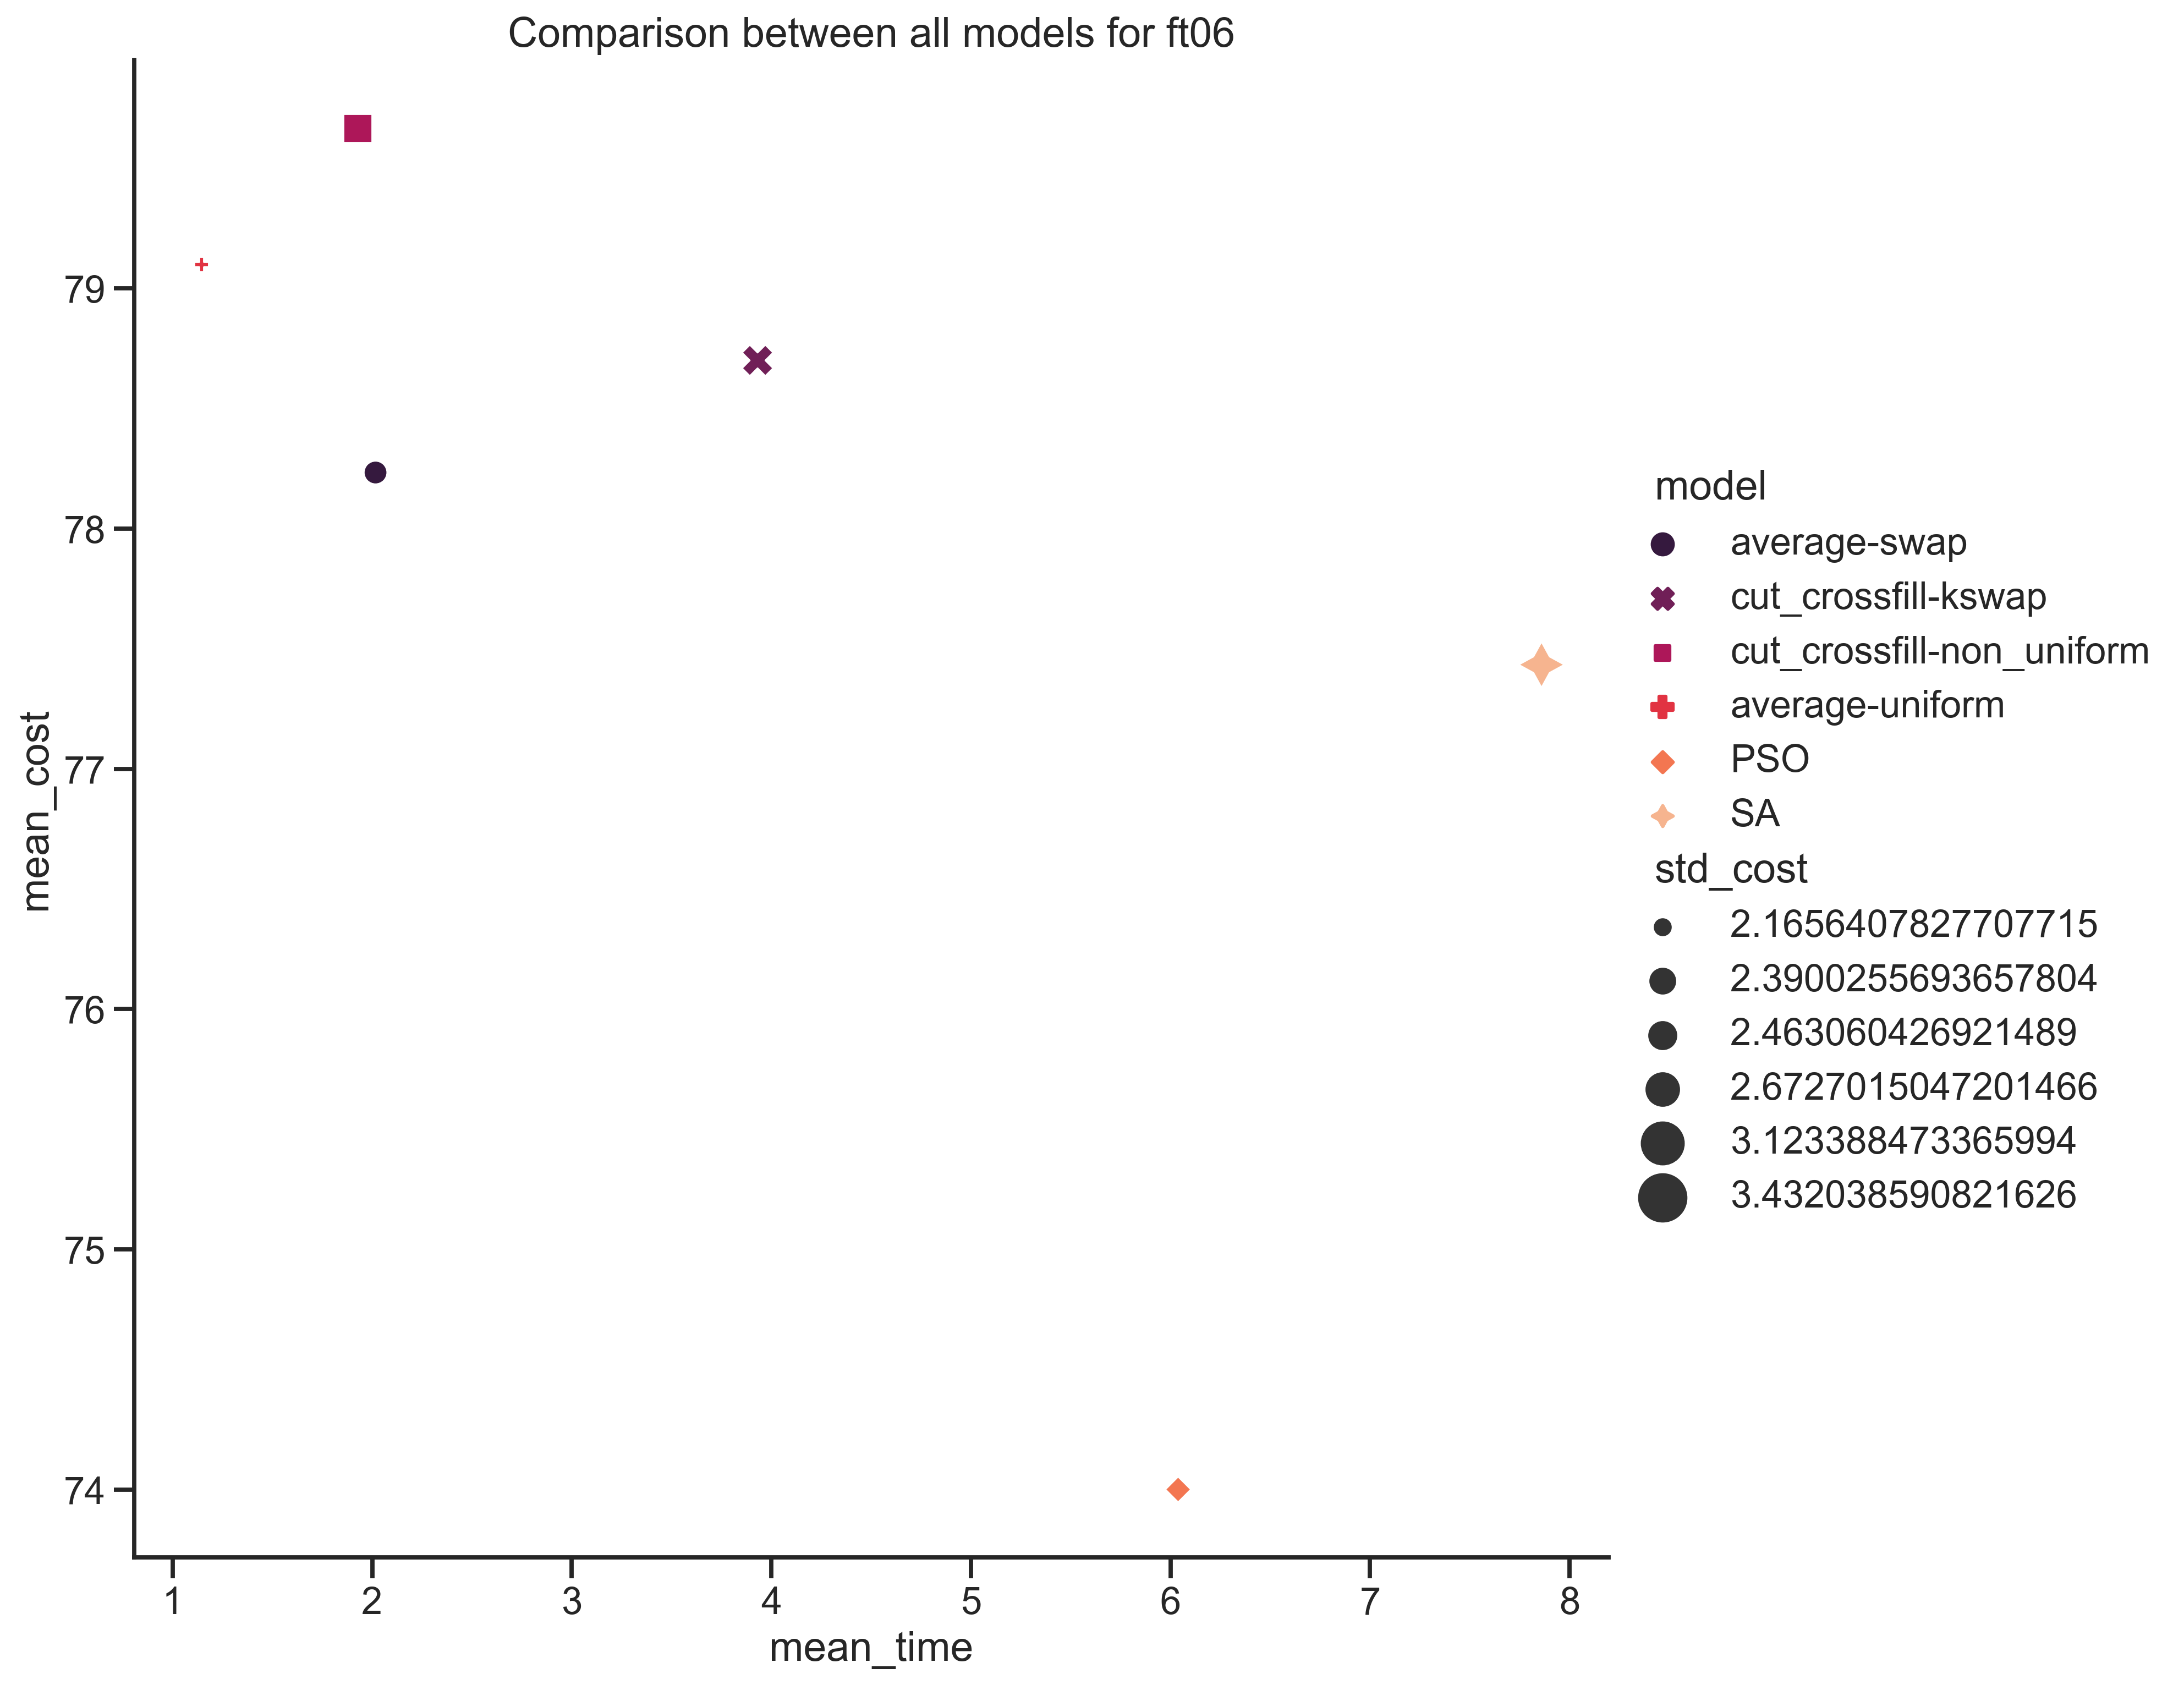

In [223]:
sns.relplot(x="mean_time", y="mean_cost", hue="model", size="std_cost", 
            data=results_df[results_df['problem'] == 'ft06'], sizes=(40, 400),
            palette="rocket", height=10, style='model')
plt.title('Comparison between all models for ft06')

Text(0.5, 1.0, 'Comparison between all models for la10')

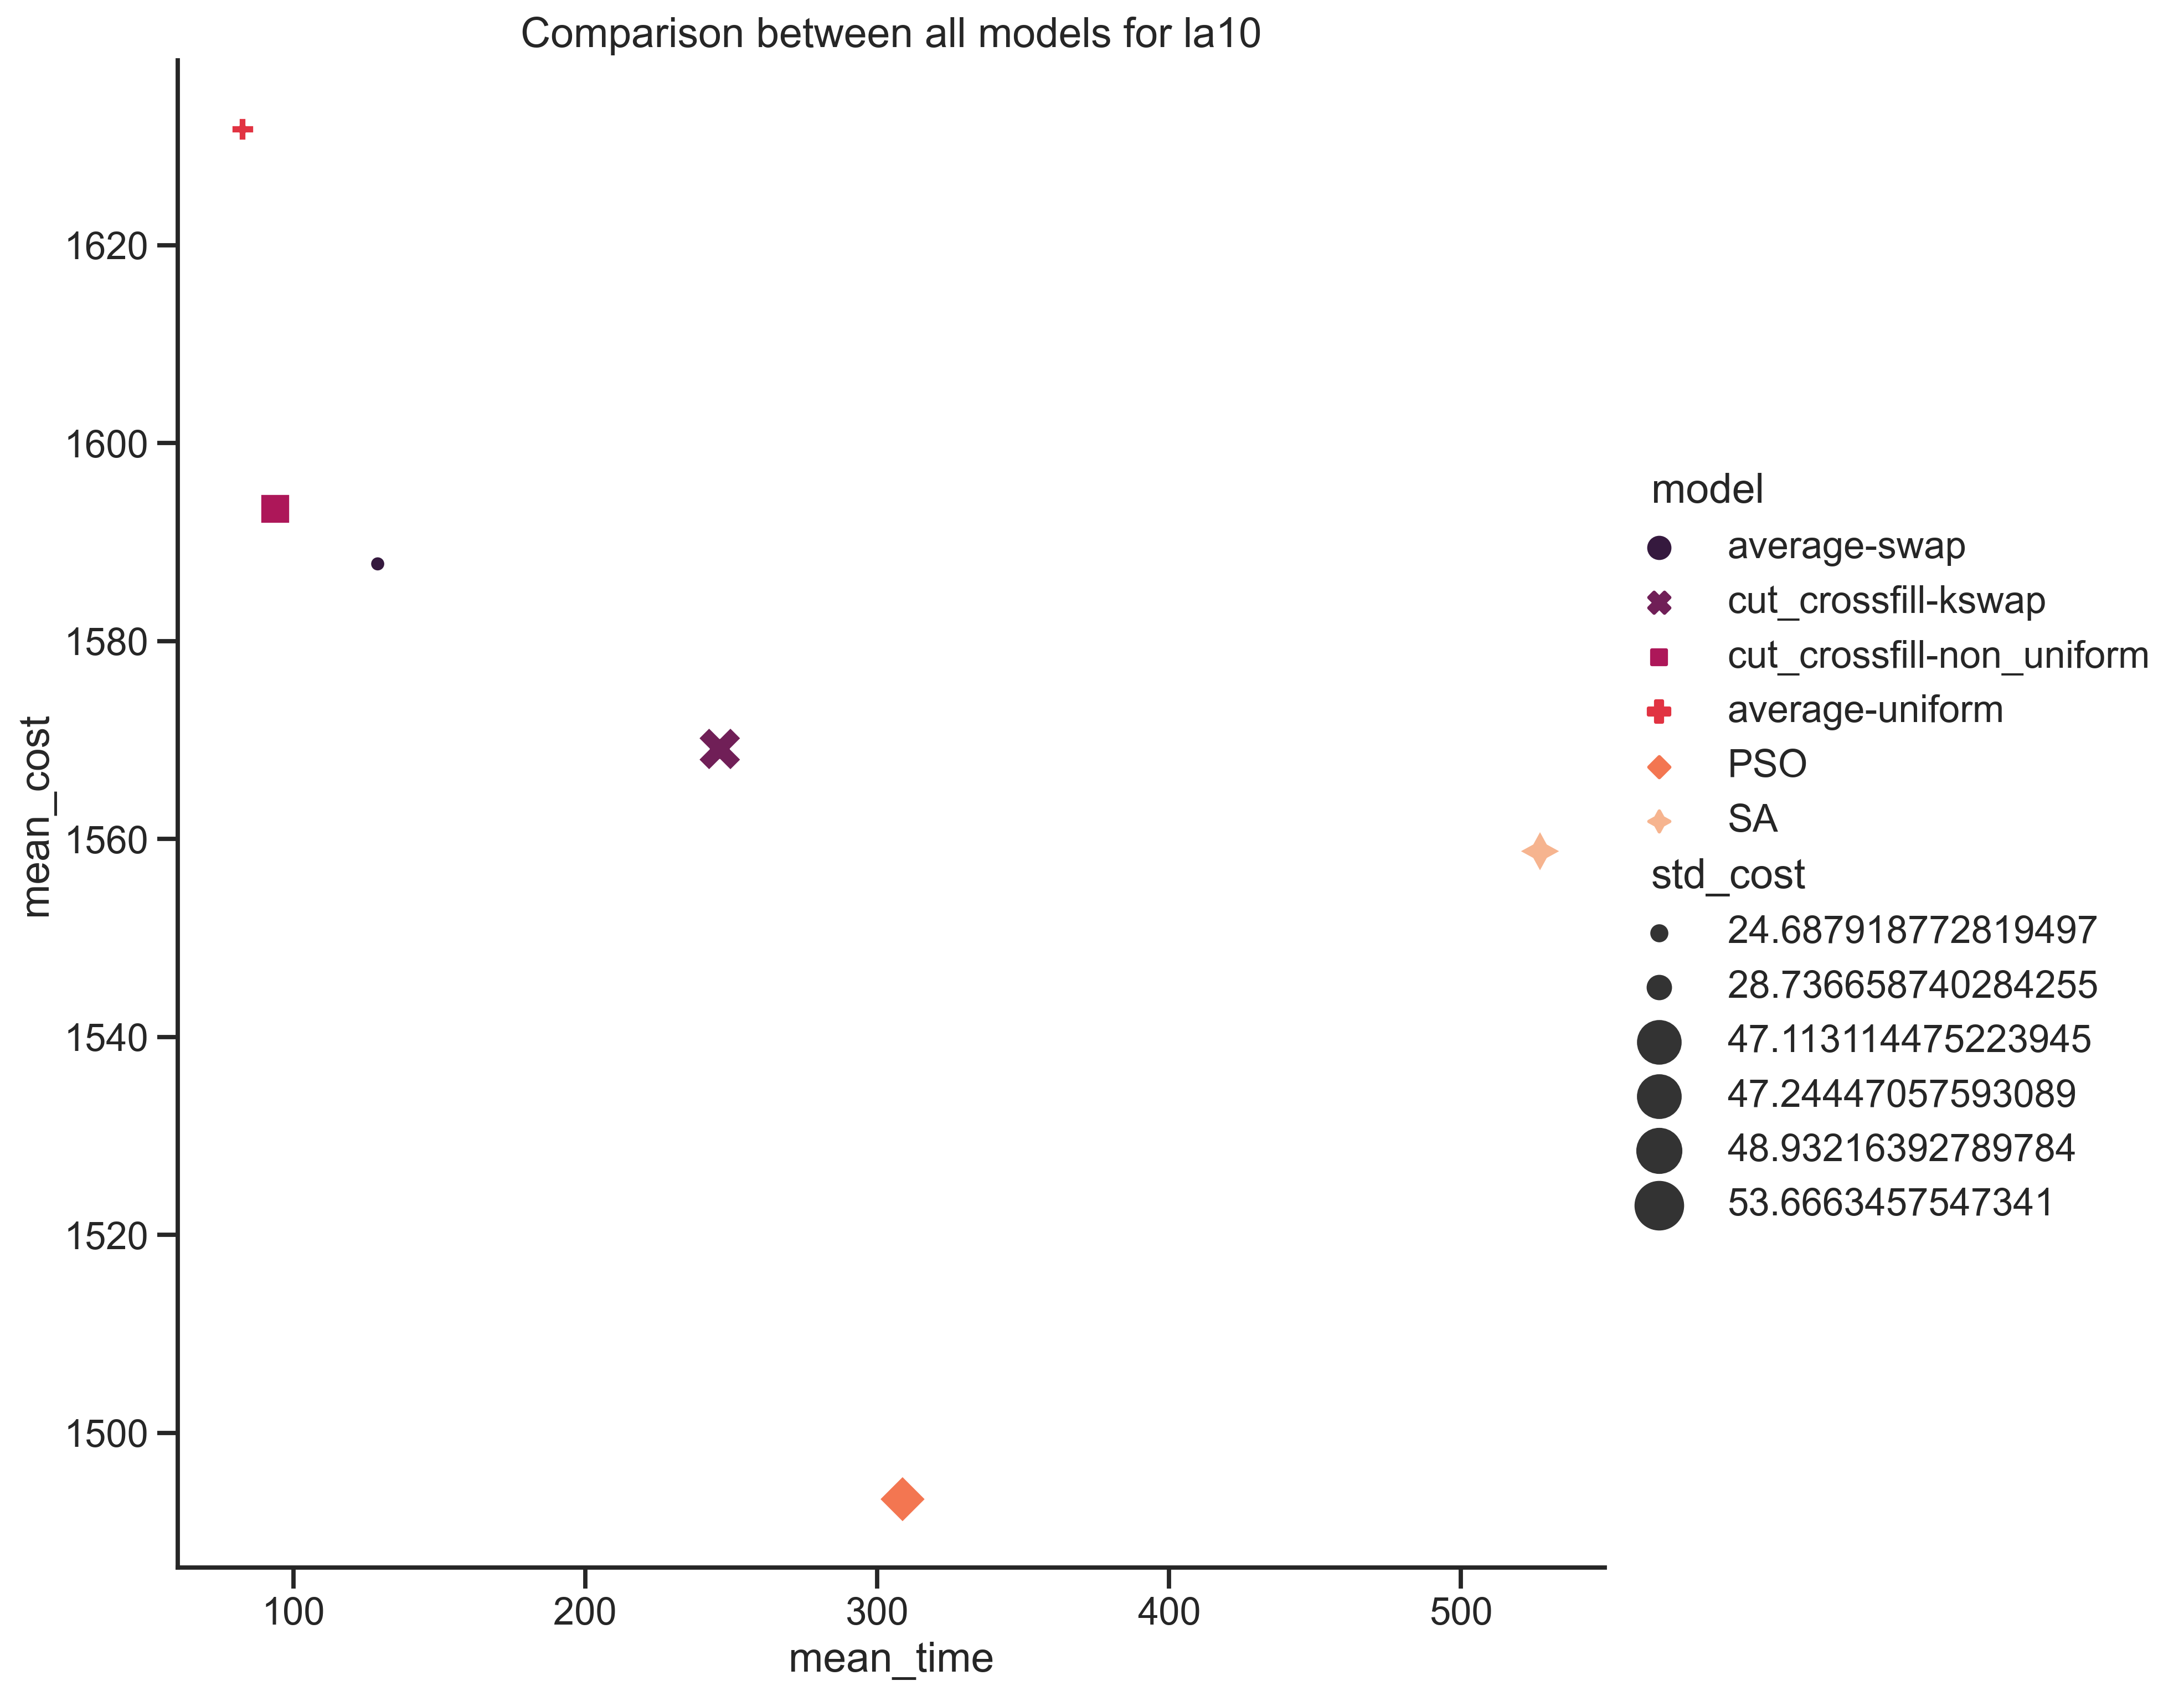

In [224]:
sns.relplot(x="mean_time", y="mean_cost", hue="model", size="std_cost", 
            data=results_df[results_df['problem'] == 'la10'], sizes=(40, 400),
            palette="rocket", height=10, style='model')
plt.title('Comparison between all models for la10')

Text(0.5, 1.0, 'Comparison between all models for la20')

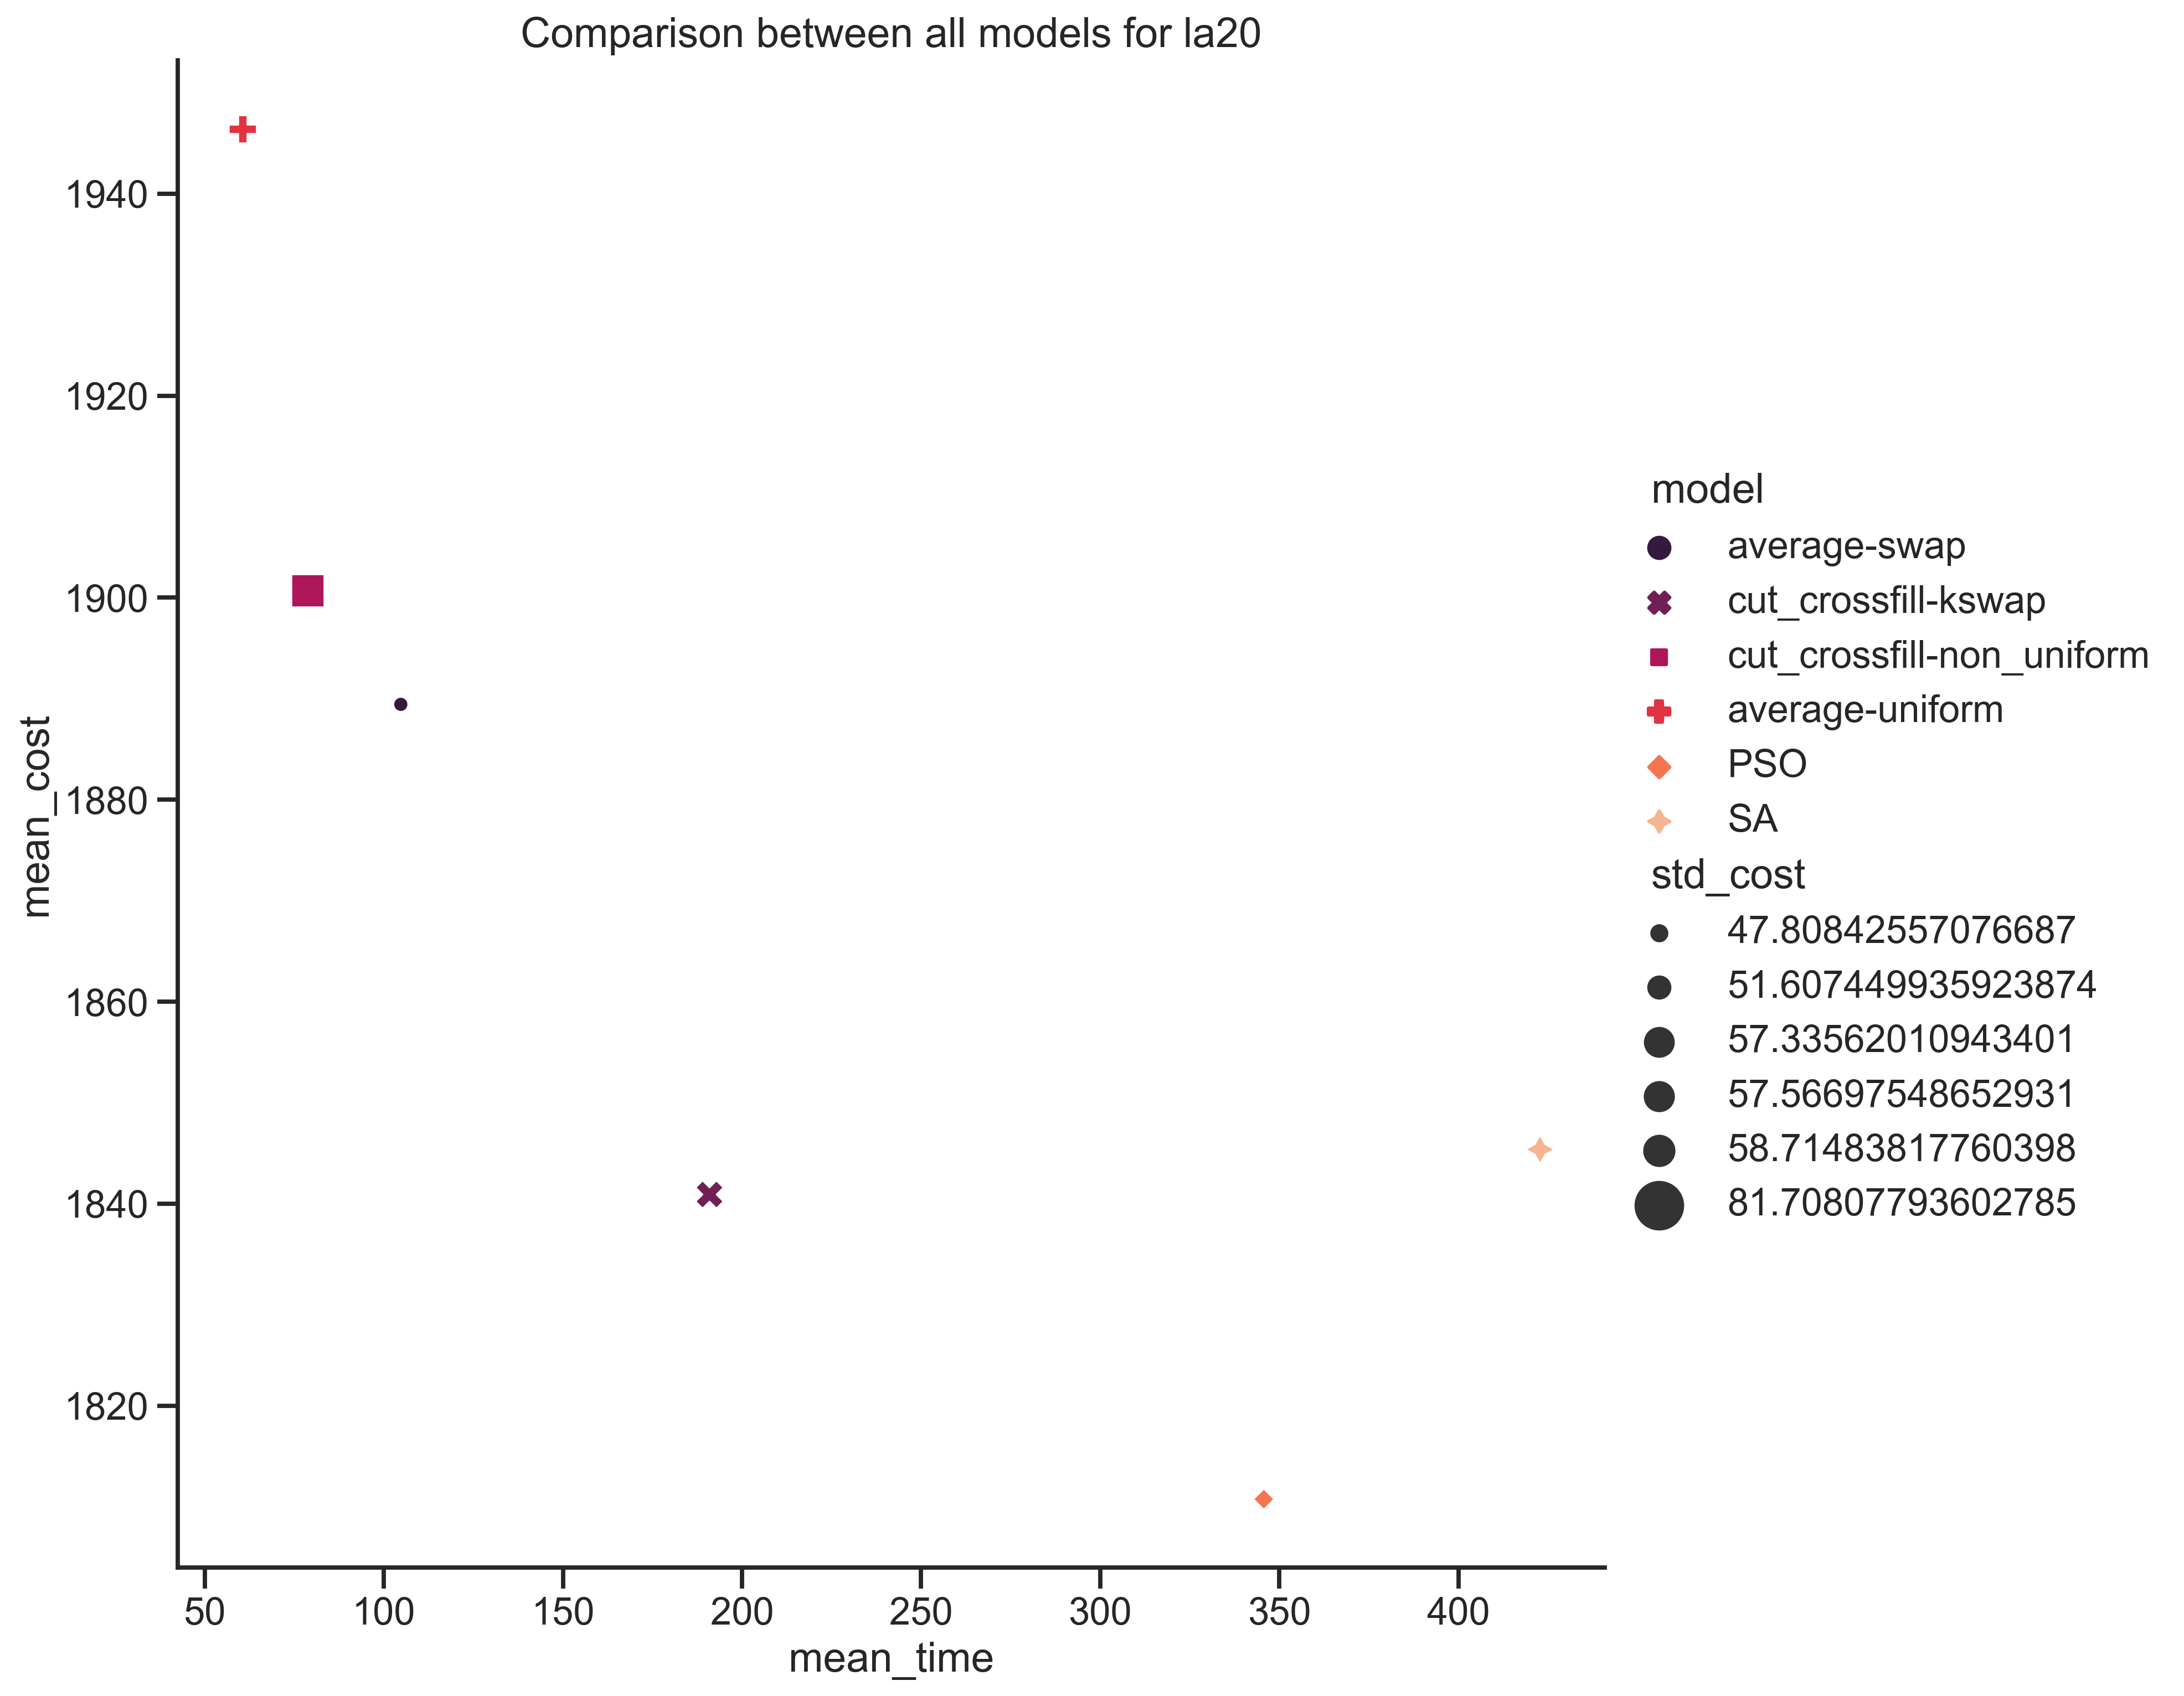

In [225]:
sns.relplot(x="mean_time", y="mean_cost", hue="model", size="std_cost", 
            data=results_df[results_df['problem'] == 'la20'], sizes=(40, 400),
            palette="rocket", height=10, style='model')
plt.title('Comparison between all models for la20')